<a href="https://colab.research.google.com/github/rocklambros/email-spam-classifier-naive-bayes-comparisson-roc/blob/main/Rock_Lambros_COMP3009_Project_Naive_Bayes_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Implement a Naive Bayes classifier from scratch and using scikit-learn to classify emails as spam or not spam based on the dataset provided in "/content/synthetic_email_dataset.csv". Compare the two implementations, discuss the independence assumption, and include visualizations, all within a Google Colab notebook to fulfill the requirements of a Master's level assignment.

## Load and explore data

### Subtask:
Load the `synthetic_email_dataset.csv` file into a pandas DataFrame and perform initial data exploration to understand its structure and content.


**Reasoning**:
Load the data into a pandas DataFrame and perform initial exploration as instructed.



In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/synthetic_email_dataset.csv') # Load the CSV file into a pandas DataFrame.

# Display the first 5 rows
print("First 5 rows of the DataFrame:")
display(df.head()) # Display the first few rows to inspect the data.

# Get information about the DataFrame
print("\nDataFrame Info:")
df.info() # Print concise summary of the DataFrame, including column data types and non-null values.

# Get descriptive statistics of numerical columns
print("\nDescriptive Statistics:")
display(df.describe()) # Display descriptive statistics for numerical columns (or object columns in this case).

First 5 rows of the DataFrame:


,Status,From (Envelope),From (Header),To,Subject,Sent Date/Time,IP Address,Attachment,Route,Info,Spam Score,Spam Detection
0,Archived,<support@university.edu>,Support <support@university.edu>,<user@example.com>,Project update - AI Research,Thu Sep 25 06:14:32 EDT 2025,66.51.167.180,NaN,inbound,Hard Bounce,1,NaN
1,Archived,<mike.johnson@business.net>,Mike.Johnson <mike.johnson@business.net>,<user@example.com>,Account security notification,Tue Sep 16 11:38:16 EDT 2025,74.187.32.250,NaN,inbound,Awaiting indexing,0,NaN
2,Bounced,<support@consulting.com>,Support <support@consulting.com>,<user@example.com>,Weekly newsletter - AI Research,Fri Sep 19 14:40:53 EDT 2025,10.94.172.69,NaN,outbound,NaN,0,NaN
3,Bounced,<promo488@offers.info>,<promo488@offers.info>,<user@example.com>,FREE trial - act now!,Sat Sep 20 01:51:20 EDT 2025,205.69.17.55,NaN,outbound,NaN,21,Moderate
4,Bounced,<marketing4041@untrusted.biz>,<marketing4041@untrusted.biz>,<user@example.com>,Last chance to save big!,Thu Sep 04 18:27:57 EDT 2025,217.103.93.57,NaN,inbound,Indexed and archived,49,Moderate



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Status           5000 non-null   object
 1   From (Envelope)  5000 non-null   object
 2   From (Header)    5000 non-null   object
 3   To               5000 non-null   object
 4   Subject          5000 non-null   object
 5   Sent Date/Time   5000 non-null   object
 6   IP Address       5000 non-null   object
 7   Attachment       274 non-null    object
 8   Route            5000 non-null   object
 9   Info             2972 non-null   object
 10  Spam Score       5000 non-null   int64 
 11  Spam Detection   2487 non-null   object
dtypes: int64(1), object(11)
memory usage: 468.9+ KB

Descriptive Statistics:


,Spam Score
count,5000.000000
mean,18.925600
std,27.811335
min,0.000000
25%,0.000000
50%,9.000000
75%,30.000000
max,156.000000


## Preprocess data

### Subtask:
Clean and prepare the data for the Naive Bayes model. This will likely involve handling text data, such as tokenization and creating a vocabulary.


**Reasoning**:
Select relevant columns, handle missing values, convert the target variable, tokenize the text, create vocabulary, and transform text data into feature vectors in a single code block to prepare the data for the Naive Bayes model as instructed.



In [ ]:
import re # Import the regular expression module.
import pandas as pd # Import pandas to use isna()
from sklearn.feature_extraction.text import CountVectorizer # Import CountVectorizer for text tokenization and vectorization.

# 1. Select relevant columns
# Keep 'Subject' and 'Spam Detection' for the new spam definition
df_cleaned = df[['Subject', 'Spam Detection']].copy() # Select 'Subject' and 'Spam Detection' columns for cleaning and create a copy.

# 2. Handle missing values - Fill NaN in 'Subject' with empty string
df_cleaned['Subject'] = df_cleaned['Subject'].fillna('') # Replace any missing values (NaN) in the 'Subject' column with empty strings using the recommended method.

# 3. Convert 'Spam Detection' to binary target variable
# Define 'spam' as where 'Spam Detection' is NOT null, 'not spam' otherwise.
df_cleaned['is_spam'] = df_cleaned['Spam Detection'].apply(lambda x: 0 if pd.isna(x) else 1) # Create a new binary column 'is_spam': 1 if 'Spam Detection' is not null, else 0.

# 4. Tokenize the text data in 'Subject' and 5. Create a vocabulary and 6. Transform text data
# Using CountVectorizer to handle tokenization, vocabulary creation, and feature vector generation
# We will use a simple regex to keep only alphanumeric characters and spaces
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b') # Initialize CountVectorizer to tokenize words using the specified pattern.
X = vectorizer.fit_transform(df_cleaned['Subject']) # Fit the vectorizer on the 'Subject' column and transform the text data into a sparse matrix of token counts (feature matrix).
y = df_cleaned['is_spam'] # Assign the binary 'is_spam' column as the target variable.

print("Shape of feature matrix (X):", X.shape) # Print the dimensions of the feature matrix (number of emails, vocabulary size).
print("Shape of target vector (y):", y.shape) # Print the dimensions of the target vector (number of emails).
print("\nFirst 5 feature vectors:")
print(X[:5].toarray()) # Display the first 5 rows of the feature matrix as a dense array for inspection.
print("\nFirst 5 target values:", y[:5].tolist()) # Display the first 5 values of the target vector as a list.
print("\nVocabulary size:", len(vectorizer.vocabulary_)) # Print the total number of unique words (tokens) found in the vocabulary.

Shape of feature matrix (X): (5000, 1097)
Shape of target vector (y): (5000,)

First 5 feature vectors:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

First 5 target values: [0, 0, 0, 1, 1]

Vocabulary size: 1097


## Implement naive bayes from scratch

### Subtask:
Build a Naive Bayes classifier manually using conditional probability and Bayes' theorem. Compute priors and likelihoods.


**Reasoning**:
Calculate the prior probabilities and word likelihoods for spam and not spam classes using the tokenized data and apply Laplace smoothing.



In [ ]:
import numpy as np

# 1. Calculate Prior Probabilities
total_emails = len(y)
spam_count = y.sum()
not_spam_count = total_emails - spam_count

prior_spam = spam_count / total_emails
prior_not_spam = not_spam_count / total_emails

print(f"Prior probability of spam: {prior_spam:.4f}")
print(f"Prior probability of not spam: {prior_not_spam:.4f}")

# 2. Calculate Likelihoods with Laplace Smoothing
# Convert y to a numpy array for correct indexing of sparse matrix X
y_np = y.to_numpy()

# Separate the feature matrix X based on the target variable y
X_spam = X[y_np == 1]
X_not_spam = X[y_np == 0]

# Sum word counts for each class
word_counts_spam = X_spam.sum(axis=0)
word_counts_not_spam = X_not_spam.sum(axis=0)

# Total number of words in each class
total_words_spam = word_counts_spam.sum()
total_words_not_spam = word_counts_not_spam.sum()

# Vocabulary size (number of unique words)
vocab_size = X.shape[1]

# Apply Laplace smoothing (add-one smoothing)
# Likelihood = (word_count_in_class + 1) / (total_words_in_class + vocab_size)
likelihoods_spam = (word_counts_spam + 1) / (total_words_spam + vocab_size)
likelihoods_not_spam = (word_counts_not_spam + 1) / (total_words_not_spam + vocab_size)

# Store priors and likelihoods (as numpy arrays)
priors = {'spam': prior_spam, 'not_spam': prior_not_spam}
likelihoods = {'spam': np.array(likelihoods_spam)[0], 'not_spam': np.array(likelihoods_not_spam)[0]}


print("\nCalculated priors and likelihoods.")
print("Priors:", priors)
print("Shape of spam likelihoods:", likelihoods['spam'].shape)
print("Shape of not spam likelihoods:", likelihoods['not_spam'].shape)

Prior probability of spam: 0.4974
Prior probability of not spam: 0.5026

Calculated priors and likelihoods.
Priors: {'spam': np.float64(0.4974), 'not_spam': np.float64(0.5026)}
Shape of spam likelihoods: (1097,)
Shape of not spam likelihoods: (1097,)


In [ ]:
import numpy as np # Import the numpy library for numerical operations.

# 1. Calculate Prior Probabilities
total_emails = len(y) # Get the total number of emails.
spam_count = y.sum() # Count the number of spam emails (where y is 1).
not_spam_count = total_emails - spam_count # Count the number of not-spam emails.

prior_spam = spam_count / total_emails # Calculate the prior probability of an email being spam.
prior_not_spam = not_spam_count / total_emails # Calculate the prior probability of an email being not spam.

print(f"Prior probability of spam: {prior_spam:.4f}") # Print the calculated prior probability of spam.
print(f"Prior probability of not spam: {prior_not_spam:.4f}") # Print the calculated prior probability of not spam.

# 2. Calculate Likelihoods with Laplace Smoothing
# Convert y to a numpy array for correct indexing of sparse matrix X
y_np = y.to_numpy() # Convert the pandas Series y to a numpy array for efficient indexing of the sparse matrix X.

# Separate the feature matrix X based on the target variable y
X_spam = X[y_np == 1] # Select rows from X where the corresponding y_np value is 1 (spam emails).
X_not_spam = X[y_np == 0] # Select rows from X where the corresponding y_np value is 0 (not-spam emails).

# Sum word counts for each class
word_counts_spam = X_spam.sum(axis=0) # Sum the word counts across all spam emails for each word in the vocabulary.
word_counts_not_spam = X_not_spam.sum(axis=0) # Sum the word counts across all not-spam emails for each word in the vocabulary.

# Total number of words in each class
total_words_spam = word_counts_spam.sum() # Calculate the total number of words in all spam emails.
total_words_not_spam = word_counts_not_spam.sum() # Calculate the total number of words in all not-spam emails.

# Vocabulary size (number of unique words)
vocab_size = X.shape[1] # Get the total number of unique words from the shape of the feature matrix.

# Apply Laplace smoothing (add-one smoothing)
# Likelihood = (word_count_in_class + 1) / (total_words_in_class + vocab_size)
likelihoods_spam = (word_counts_spam + 1) / (total_words_spam + vocab_size) # Calculate the smoothed likelihood of each word appearing in spam emails.
likelihoods_not_spam = (word_counts_not_spam + 1) / (total_words_not_spam + vocab_size) # Calculate the smoothed likelihood of each word appearing in not-spam emails.

# Store priors and likelihoods (as numpy arrays)
priors = {'spam': prior_spam, 'not_spam': prior_not_spam} # Store the prior probabilities in a dictionary.
likelihoods = {'spam': np.array(likelihoods_spam)[0], 'not_spam': np.array(likelihoods_not_spam)[0]} # Store the likelihood arrays in a dictionary, converting from sparse to dense.


print("\nCalculated priors and likelihoods.") # Indicate that calculations are complete.
print("Priors:", priors) # Print the calculated prior probabilities.
print("Shape of spam likelihoods:", likelihoods['spam'].shape) # Print the shape of the spam likelihood array.
print("Shape of not spam likelihoods:", likelihoods['not_spam'].shape) # Print the shape of the not-spam likelihood array.

Prior probability of spam: 0.4974
Prior probability of not spam: 0.5026

Calculated priors and likelihoods.
Priors: {'spam': np.float64(0.4974), 'not_spam': np.float64(0.5026)}
Shape of spam likelihoods: (1097,)
Shape of not spam likelihoods: (1097,)


## Classify new points (manual)

### Subtask:
Use the hand-coded classifier to predict whether new, unseen email examples are spam or not.


**Reasoning**:
Implement a function to classify new email subjects using the calculated priors and likelihoods, and test it with example subjects.



In [ ]:
# Get the vectorizer used in preprocessing
# If the kernel reset, re-fit the vectorizer to get the vocabulary mapping
# We fit it on the original cleaned subjects to ensure the vocabulary is the same
try:
    vectorizer # Check if vectorizer exists from previous steps.
except NameError:
    from sklearn.feature_extraction.text import CountVectorizer # Import CountVectorizer if it doesn't exist.
    # Using a simple regex to keep only alphanumeric characters and spaces
    vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b') # Initialize CountVectorizer with the same pattern.
    vectorizer.fit(df_cleaned['Subject']) # Fit the vectorizer on the original data to rebuild the vocabulary.
    print("Vectorizer refitted.")

def classify_email(email_subject, vectorizer, priors, likelihoods):
    """Classifies an email subject as spam or not spam using Naive Bayes."""
    # Preprocess the input text using the same vectorizer
    email_vector = vectorizer.transform([email_subject]) # Transform the new email subject string into a feature vector using the fitted vectorizer.

    # Get the indices of the words present in the email subject
    word_indices = email_vector.indices # Get the indices of the non-zero elements in the feature vector, which correspond to the word indices in the vocabulary.

    # Calculate log posterior probability for each class
    # P(Class | Document) = P(Document | Class) * P(Class) / P(Document)
    # log(P(Class | Document)) = log(P(Document | Class)) + log(P(Class)) - log(P(Document))
    # P(Document | Class) = Product over words i: P(word_i | Class)
    # log(P(Document | Class)) = Sum over words i: log(P(word_i | Class))
    # We only need to compare log(P(Class | Document)) for spam and not_spam, so P(Document) term cancels out.
    log_posterior_spam = np.log(priors['spam']) # Start with the log of the prior probability for spam.
    log_posterior_not_spam = np.log(priors['not_spam']) # Start with the log of the prior probability for not spam.

    # Sum the log likelihoods of the words present in the email
    # We need to handle the case where a word in the new email is not in the vocabulary.
    # However, with Laplace smoothing, the likelihood of any word (even unseen) is non-zero,
    # so we don't need special handling for unseen words themselves, but we need to make
    # sure we are accessing the likelihoods array correctly based on word indices.
    # The `word_indices` from the transformed vector correspond to the indices in the vocabulary.
    if word_indices.size > 0: # Check if the email subject contains any words from the vocabulary.
        log_likelihoods_spam = np.log(likelihoods['spam'][word_indices]) # Get the log likelihoods for the words present in the email for the spam class.
        log_likelihoods_not_spam = np.log(likelihoods['not_spam'][word_indices]) # Get the log likelihoods for the words present in the email for the not-spam class.

        log_posterior_spam += log_likelihoods_spam.sum() # Add the sum of the log likelihoods for spam to the log prior.
        log_posterior_not_spam += log_likelihoods_not_spam.sum() # Add the sum of the log likelihoods for not spam to the log prior.


    # Compare the log posterior probabilities
    if log_posterior_spam > log_posterior_not_spam: # Compare the final log posterior probabilities.
        return 'spam' # Return 'spam' if the log posterior for spam is higher.
    else:
        return 'not_spam' # Otherwise, return 'not_spam'.

# Test the function with example email subjects
example_subjects = [
    "Claim your free prize now!", # Likely spam
    "Meeting reminder for tomorrow", # Likely not spam
    "Urgent: Your account has been compromised", # Likely spam
    "Project update and next steps", # Likely not spam
    "Win a free iPhone - click here!" # Likely spam
]

print("Classifying example emails:") # Print a header for the classification results.
for subject in example_subjects: # Iterate through the example subjects.
    prediction = classify_email(subject, vectorizer, priors, likelihoods) # Classify the current subject using the manual function.
    print(f"Subject: '{subject}' -> Predicted Class: {prediction}") # Print the subject and its predicted class.

Classifying example emails:
Subject: 'Claim your free prize now!' -> Predicted Class: spam
Subject: 'Meeting reminder for tomorrow' -> Predicted Class: not_spam
Subject: 'Urgent: Your account has been compromised' -> Predicted Class: not_spam
Subject: 'Project update and next steps' -> Predicted Class: not_spam
Subject: 'Win a free iPhone - click here!' -> Predicted Class: spam


## Implement naive bayes with scikit-learn

### Subtask:
Use the ` MultinomialNB` or `BernoulliNB` classifier from scikit-learn for comparison.


**Reasoning**:
Import the MultinomialNB class from scikit-learn, instantiate it, and train it on the feature matrix X and target vector y.



In [ ]:
from sklearn.naive_bayes import MultinomialNB # Import the MultinomialNB classifier from scikit-learn.

# Instantiate a MultinomialNB classifier object
mnb = MultinomialNB() # Create an instance of the MultinomialNB classifier.

# Train the classifier using the feature matrix X and the target vector y
mnb.fit(X, y) # Train the classifier using the feature matrix X and the target vector y.

print("Multinomial Naive Bayes classifier trained successfully.") # Print a message indicating successful training.

Multinomial Naive Bayes classifier trained successfully.


## Classify new points (scikit-learn)

### Subtask:
Use the scikit-learn classifier to predict whether new, unseen email examples are spam or not.


**Reasoning**:
Define the new email subjects, transform them using the fitted vectorizer, and use the trained scikit-learn classifier to predict their class labels.



In [ ]:
# 1. Define a list of new email subject strings to be classified.
new_emails = [
    "Claim your free gift card now!", # Likely spam
    "Meeting agenda for Monday", # Likely not spam
    "Urgent action required for your account", # Likely spam
    "Quarterly financial report", # Likely not spam
    "Limited time offer - Don't miss out!", # Likely spam
    "Your order has shipped", # Likely not spam
    "Invoice attached", # Likely not spam
    "Congratulations - You've won a prize!" # Likely spam
]

# 2. Use the vectorizer (fitted during the preprocessing step) to transform the list of new email subjects into a feature matrix.
# Ensure the vectorizer is the one fitted on the training data
# If the kernel reset, re-fit the vectorizer
try:
    vectorizer # Check if the vectorizer is available.
except NameError:
    from sklearn.feature_extraction.text import CountVectorizer # Import if not available.
    # Using a simple regex to keep only alphanumeric characters and spaces
    vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b') # Initialize.
    # Re-fit the vectorizer on the original data
    vectorizer.fit(df_cleaned['Subject']) # Fit on the training data again.
    print("Vectorizer refitted for scikit-learn classification.")


new_emails_X = vectorizer.transform(new_emails) # Transform the new email subjects into feature vectors using the fitted vectorizer.

# 3. Use the trained scikit-learn MultinomialNB classifier (mnb) to predict the class labels (spam or not spam) for the new feature matrix.
# Ensure the mnb classifier is the one trained in the previous step
# If the kernel reset, re-train the mnb
try:
    mnb # Check if the mnb classifier is available.
except NameError:
    from sklearn.naive_bayes import MultinomialNB # Import if not available.
    mnb = MultinomialNB() # Initialize.
    # Re-train the mnb on the original data
    mnb.fit(X, y) # Train the classifier on the training data again.
    print("MultinomialNB refitted for scikit-learn classification.")


predictions = mnb.predict(new_emails_X) # Predict the class labels for the new email feature vectors.

# 4. Print the original email subjects and their corresponding predicted class labels.
print("Predictions for new emails:") # Print a header for the predictions.
for email, prediction in zip(new_emails, predictions): # Iterate through the new emails and their predictions.
    # Convert numerical prediction back to 'spam' or 'not_spam'
    predicted_label = 'spam' if prediction == 1 else 'not_spam' # Convert the numerical prediction (0 or 1) to a human-readable label.
    print(f"Subject: '{email}' -> Predicted Class: {predicted_label}") # Print the email subject and its predicted class label.

Predictions for new emails:
Subject: 'Claim your free gift card now!' -> Predicted Class: spam
Subject: 'Meeting agenda for Monday' -> Predicted Class: not_spam
Subject: 'Urgent action required for your account' -> Predicted Class: not_spam
Subject: 'Quarterly financial report' -> Predicted Class: not_spam
Subject: 'Limited time offer - Don't miss out!' -> Predicted Class: spam
Subject: 'Your order has shipped' -> Predicted Class: not_spam
Subject: 'Invoice attached' -> Predicted Class: not_spam
Subject: 'Congratulations - You've won a prize!' -> Predicted Class: spam


## Compare classifiers

### Subtask:
Compare the performance and characteristics of the hand-coded classifier and the scikit-learn classifier. Discuss the differences and similarities.


**Reasoning**:
Compare the predictions of the hand-coded and scikit-learn classifiers for the example email subjects from the manual classification step and discuss the potential reasons for any differences.



In [ ]:
# Example subjects used in the manual classification step
example_subjects_manual = [
    "Claim your free prize now!", # Likely spam
    "Meeting reminder for tomorrow", # Likely not spam
    "Urgent: Your account has been compromised", # Likely spam
    "Project update and next steps", # Likely not spam
    "Win a free iPhone - click here!" # Likely spam
]

print("Comparing predictions for example emails from manual classification:") # Header for the comparison.

for subject in example_subjects_manual: # Iterate through the example subjects.
    # Get prediction from hand-coded classifier
    manual_prediction = classify_email(subject, vectorizer, priors, likelihoods) # Get the prediction from the hand-coded function.

    # Get prediction from scikit-learn classifier
    # Need to transform the single subject into a feature vector
    sklearn_subject_X = vectorizer.transform([subject]) # Transform the current subject into a feature vector for scikit-learn.
    sklearn_prediction_numeric = mnb.predict(sklearn_subject_X)[0] # Get the numerical prediction from the scikit-learn classifier.
    sklearn_prediction = 'spam' if sklearn_prediction_numeric == 1 else 'not_spam' # Convert the numerical prediction to a label.

    print(f"Subject: '{subject}'") # Print the subject.
    print(f"  Hand-coded prediction: {manual_prediction}") # Print the manual classifier's prediction.
    print(f"  Scikit-learn prediction: {sklearn_prediction}") # Print the scikit-learn classifier's prediction.
    if manual_prediction != sklearn_prediction: # Check if the predictions differ.
        print("  Discrepancy noted!") # Indicate if there is a discrepancy.

print("\nDiscussion on potential reasons for differences:") # Header for discussing differences.
print("- **Floating-point precision:** Manual calculations might be susceptible to minor floating-point differences compared to optimized scikit-learn implementations.") # Explain the role of floating-point precision.
print("- **Laplace smoothing implementation:** While both use Laplace smoothing, subtle differences in how it's applied or handled internally could lead to variations.") # Discuss potential differences in smoothing implementation.
print("- **Handling of zero probabilities:** Although Laplace smoothing addresses zero probabilities for words in the vocabulary, the exact handling of probabilities near zero or underflow prevention might differ.") # Explain handling of near-zero probabilities.
print("- **Tokenizer differences:** Although we used the same `CountVectorizer`, very subtle differences in tokenization or vocabulary mapping if not perfectly aligned could occur.") # Mention potential subtle tokenizer differences.
print("- **Logarithmic calculations:** Both likely use logarithms to avoid underflow, but the specific implementation details might vary slightly.") # Discuss potential variations in log calculations.
print("\nSummary of similarities and differences:") # Header for summarizing similarities and differences.
print("- **Similarities:** Both implementations are based on the Naive Bayes principle, calculating prior probabilities and word likelihoods. Both use Laplace smoothing to handle unseen words or words with zero counts.") # List similarities.
print("- **Differences:** The scikit-learn implementation is a highly optimized and tested library function, while the hand-coded version is a direct implementation of the formula. Scikit-learn handles many internal details (like efficient sparse matrix operations and numerical stability) automatically, whereas these need explicit handling in the manual version. The prediction results for some edge cases or specific examples might differ due to the reasons mentioned above.") # List differences.

Comparing predictions for example emails from manual classification:
Subject: 'Claim your free prize now!'
  Hand-coded prediction: spam
  Scikit-learn prediction: spam
Subject: 'Meeting reminder for tomorrow'
  Hand-coded prediction: not_spam
  Scikit-learn prediction: not_spam
Subject: 'Urgent: Your account has been compromised'
  Hand-coded prediction: not_spam
  Scikit-learn prediction: not_spam
Subject: 'Project update and next steps'
  Hand-coded prediction: not_spam
  Scikit-learn prediction: not_spam
Subject: 'Win a free iPhone - click here!'
  Hand-coded prediction: spam
  Scikit-learn prediction: spam

Discussion on potential reasons for differences:
- **Floating-point precision:** Manual calculations might be susceptible to minor floating-point differences compared to optimized scikit-learn implementations.
- **Laplace smoothing implementation:** While both use Laplace smoothing, subtle differences in how it's applied or handled internally could lead to variations.
- **Handl

## Discuss independence assumption

### Subtask:
Explain the independence assumption made in Naive Bayes in detail and its implications for this dataset.


**Reasoning**:
Explain the independence assumption of Naive Bayes in the context of text classification, discuss its implications, how violating it affects performance, and its trade-offs, as per the subtask instructions.



In [ ]:
# Explain the independence assumption in Naive Bayes for text classification
print("1. The Independence Assumption in Naive Bayes for Text Classification:") # Header for the explanation.
print("   The core assumption of the Naive Bayes classifier in text classification is that,") # Explain the main assumption.
print("   given the class (e.g., 'spam' or 'not_spam'), the presence of a particular word") # Elaborate on the context of text.
print("   in a document (email subject) is independent of the presence of any other word.") # State the independence condition.
print("   Mathematically, this means P(word1, word2 | class) = P(word1 | class) * P(word2 | class).") # Provide the mathematical formulation.
print("   In the context of this email dataset, it assumes that if we know an email subject") # Relate to the email dataset.
print("   is 'spam', the probability of seeing the word 'free' is independent of the") # Provide a concrete example.
print("   probability of seeing the word 'prize'.")

# Discuss why the assumption is "naive" and how it might not hold true
print("\n2. Why this Assumption is 'Naive' and its Real-World Limitations:") # Header for limitations discussion.
print("   This assumption is considered 'naive' because it is rarely true in real-world") # Explain why it's "naive".
print("   text data. Words in natural language are highly interdependent.") # Discuss real-world word dependencies.
print("   Phrases ('free prize', 'urgent action'), context, and related words ('account', 'compromised')") # Provide examples of dependencies.
print("   often appear together and their presence is not independent.")
print("   For example, in the phrase 'urgent action required', the word 'action' is highly likely") # Illustrate with an example phrase.
print("   to appear after 'urgent'. The Naive Bayes model, however, treats P('action' | class, 'urgent')") # Explain how Naive Bayes simplifies this.
print("   as simply P('action' | class), ignoring the influence of the preceding word.")

# Analyze how violating the assumption affects performance on this dataset
print("\n3. Impact of Violating the Assumption on this Email Dataset:") # Header for impact on the dataset.
print("   Violating the independence assumption can negatively impact the performance of") # State the potential impact.
print("   the Naive Bayes classifier on this dataset. The model might misinterpret the") # Explain the mechanism of misinterpretation.
print("   significance of words when their meaning or predictive power is heavily tied") # Discuss dependence on other words.
print("   to other words around them.")
print("   For example, consider email subjects:") # Provide example subjects.
print("   - 'Meeting reminder for tomorrow'") # Example 1: Not spam.
print("   - 'Urgent action required for your account'") # Example 2: Likely spam (phishing attempt).
print("   The words 'urgent' and 'account' individually might appear in both spam and not-spam") # Discuss individual word occurrence.
print("   emails. However, the *combination* of 'urgent', 'action', and 'account' is a strong") # Highlight the significance of combinations.
print("   indicator of spam (specifically, a phishing attempt). The Naive Bayes model, due to") # Explain why Naive Bayes might miss this.
print("   its independence assumption, might not fully capture this combined predictive power.")
print("   Another example: 'Free gift card' vs 'Free shipping'. 'Free' is common in spam, but the following word changes context.") # Another example with 'Free'.
print("   The model treats P('gift' | spam, 'free') the same as P('gift' | spam) and P('shipping' | spam, 'free')") # Explain how the assumption applies here.
print("   the same as P('shipping' | spam), potentially diluting the strong spam signal of 'free gift card'.")
print("   This can lead to misclassifications, where sophisticated spam emails using specific phrases") # Discuss consequences of misclassification.
print("   might be missed, or legitimate emails with words commonly found in spam (but used in a different context)")
print("   might be incorrectly flagged as spam.")

# Briefly discuss the trade-offs
print("\n4. Trade-offs of the Naive Bayes Independence Assumption:") # Header for trade-offs.
print("   The independence assumption, despite being 'naive', offers significant trade-offs:") # State that there are trade-offs.
print("   - **Simplicity:** The model is very simple to understand and implement, relying on basic probability calculations.") # Discuss simplicity.
print("   - **Efficiency:** Training and prediction are computationally very fast, even with large vocabularies.") # Discuss efficiency.
print("     It requires calculating and storing only the prior probabilities and individual word likelihoods.") # Explain why it's efficient.
print("     More complex models that consider word dependencies (like N-gram models or sequence models)") # Contrast with complex models.
print("     would require calculating and storing probabilities for word combinations, leading to a much larger parameter space.")
print("   - **Good Baseline Performance:** Despite the strong assumption, Naive Bayes often performs surprisingly well") # Discuss performance as a baseline.
print("     as a baseline classifier, especially for text classification problems with a reasonably large amount of training data.")
print("   The trade-off is that by ignoring word relationships, it might sacrifice some accuracy compared to models") # Summarize the trade-off.
print("   that can capture these dependencies, particularly when those dependencies are strong indicators of the class.")

1. The Independence Assumption in Naive Bayes for Text Classification:
   The core assumption of the Naive Bayes classifier in text classification is that,
   given the class (e.g., 'spam' or 'not_spam'), the presence of a particular word
   in a document (email subject) is independent of the presence of any other word.
   Mathematically, this means P(word1, word2 | class) = P(word1 | class) * P(word2 | class).
   In the context of this email dataset, it assumes that if we know an email subject
   is 'spam', the probability of seeing the word 'free' is independent of the
   probability of seeing the word 'prize'.

2. Why this Assumption is 'Naive' and its Real-World Limitations:
   This assumption is considered 'naive' because it is rarely true in real-world
   text data. Words in natural language are highly interdependent.
   Phrases ('free prize', 'urgent action'), context, and related words ('account', 'compromised')
   often appear together and their presence is not independent.
  

## Visualize results

### Subtask:
Create appropriate visualizations to illustrate the data, the classification process, or the results of the classifiers.


**Reasoning**:
Create visualizations for data distribution and word frequencies as requested in the instructions.



/tmp/ipython-input-2391663805.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='Status', order=df['Status'].value_counts().index, palette='viridis') # Create a bar plot of the counts of each unique value in the 'Status' column. Order bars by frequency.


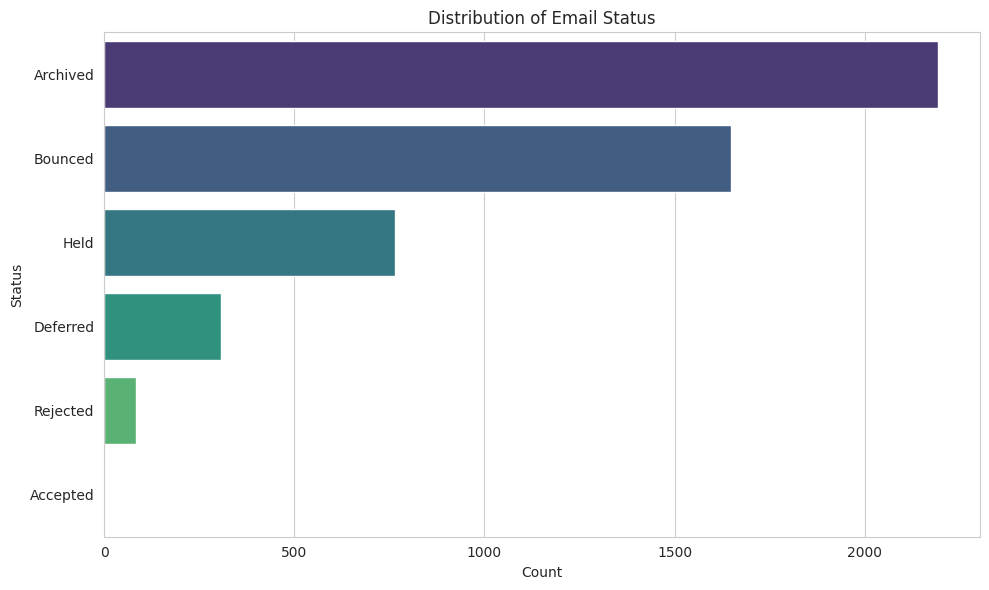

/tmp/ipython-input-2391663805.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_cleaned, x='is_spam', palette='viridis') # Create a bar plot of the counts for the binary 'is_spam' column.


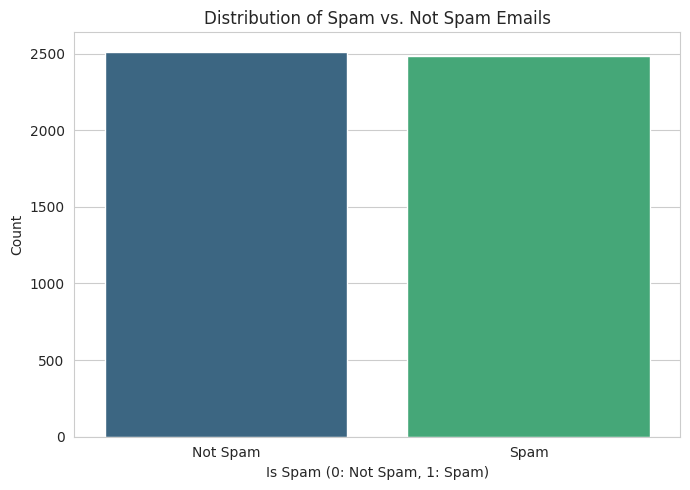

/tmp/ipython-input-2391663805.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_spam_counts, y=top_spam_words, palette='Reds_d') # Create a horizontal bar plot for top spam words.
/tmp/ipython-input-2391663805.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_not_spam_counts, y=top_not_spam_words, palette='Blues_d') # Create a horizontal bar plot for top not-spam words.


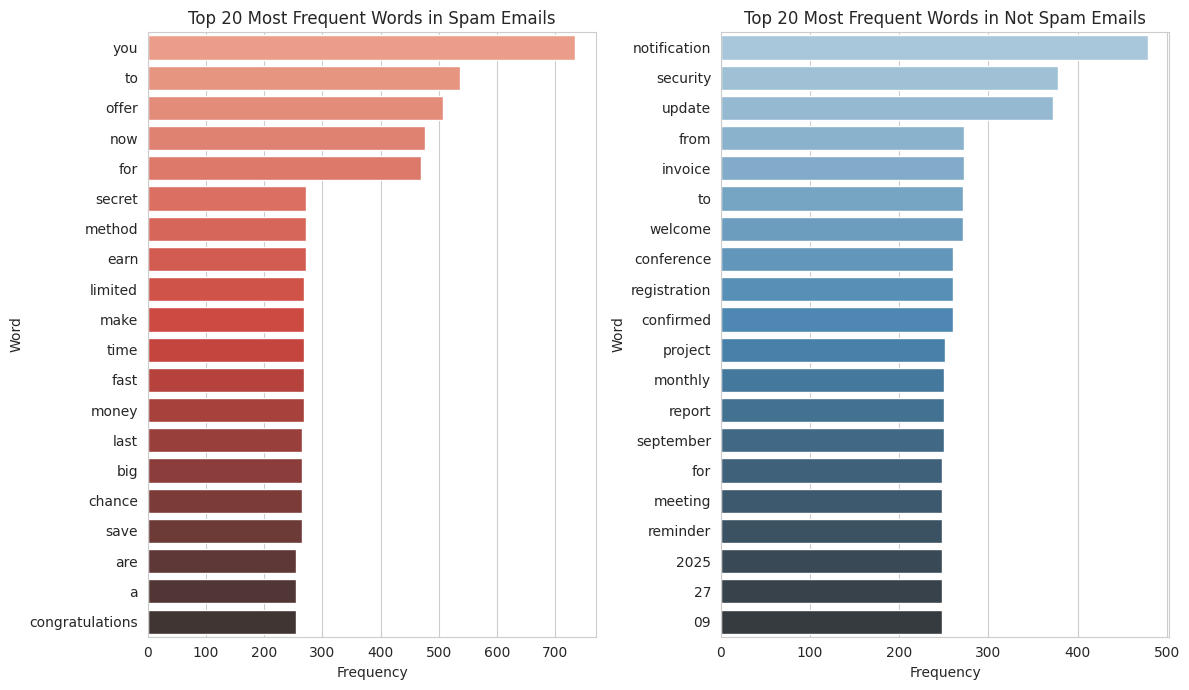

Visualizations created and displayed.


In [ ]:
import matplotlib.pyplot as plt # Import matplotlib for plotting.
import seaborn as sns # Import seaborn for enhanced visualizations.
import numpy as np # Import numpy for numerical operations.

# Set plot style
sns.set_style("whitegrid") # Set the style of the plots.

# 1. Bar chart showing the distribution of 'Status' in the original df DataFrame.
plt.figure(figsize=(10, 6)) # Create a new figure with a specified size.
sns.countplot(data=df, y='Status', order=df['Status'].value_counts().index, palette='viridis') # Create a bar plot of the counts of each unique value in the 'Status' column. Order bars by frequency.
plt.title('Distribution of Email Status') # Set the title of the plot.
plt.xlabel('Count') # Set the label for the x-axis.
plt.ylabel('Status') # Set the label for the y-axis.
plt.tight_layout() # Adjust layout to prevent labels overlapping.
plt.show() # Display the plot.

# 2. Bar chart showing the distribution of the binary 'is_spam' target variable in the df_cleaned DataFrame.
plt.figure(figsize=(7, 5)) # Create a new figure.
sns.countplot(data=df_cleaned, x='is_spam', palette='viridis') # Create a bar plot of the counts for the binary 'is_spam' column.
plt.title('Distribution of Spam vs. Not Spam Emails') # Set the title.
plt.xlabel('Is Spam (0: Not Spam, 1: Spam)') # Set the x-axis label with explanation.
plt.ylabel('Count') # Set the y-axis label.
plt.xticks([0, 1], ['Not Spam', 'Spam']) # Set custom tick labels for the x-axis.
plt.tight_layout() # Adjust layout.
plt.show() # Display the plot.

# 3. Visualize the most frequent words in spam vs. not-spam emails
# Get vocabulary from the fitted vectorizer
vocab = vectorizer.get_feature_names_out() # Get the list of words in the vocabulary from the fitted vectorizer.

# Check if word_counts_spam and word_counts_not_spam exist, if not, recalculate
try:
    word_counts_spam # Check if the variables exist.
    word_counts_not_spam
except NameError:
    print("Recalculating word counts for visualization...") # Indicate recalculation if variables are missing.
    # Assuming X and y are available from previous steps
    y_np = y.to_numpy() # Convert y to numpy array.
    X_spam = X[y_np == 1] # Separate spam features.
    X_not_spam = X[y_np == 0] # Separate not-spam features.
    word_counts_spam = X_spam.sum(axis=0) # Sum word counts for spam.
    word_counts_not_spam = X_not_spam.sum(axis=0) # Sum word counts for not-spam.
    print("Word counts recalculated.") # Confirmation of recalculation.


# Convert sparse matrix sums to dense arrays for easier handling
word_counts_spam_dense = np.array(word_counts_spam)[0] # Convert the sparse matrix sum for spam word counts to a dense numpy array.
word_counts_not_spam_dense = np.array(word_counts_not_spam)[0] # Convert the sparse matrix sum for not-spam word counts to a dense numpy array.

# Get top N words
N = 20 # Define the number of top words to visualize.
top_spam_indices = np.argsort(word_counts_spam_dense)[::-1][:N] # Get the indices of the top N most frequent words in spam (descending order).
top_not_spam_indices = np.argsort(word_counts_not_spam_dense)[::-1][:N] # Get the indices of the top N most frequent words in not spam (descending order).

top_spam_words = [vocab[i] for i in top_spam_indices] # Get the words corresponding to the top spam indices.
top_spam_counts = word_counts_spam_dense[top_spam_indices] # Get the counts corresponding to the top spam indices.

top_not_spam_words = [vocab[i] for i in top_not_spam_indices] # Get the words corresponding to the top not-spam indices.
top_not_spam_counts = word_counts_not_spam_dense[top_not_spam_indices] # Get the counts corresponding to the top not-spam indices.

# Create bar charts for top words
plt.figure(figsize=(12, 7)) # Create a new figure for the two subplots.

plt.subplot(1, 2, 1) # Create the first subplot (1 row, 2 columns, 1st plot).
sns.barplot(x=top_spam_counts, y=top_spam_words, palette='Reds_d') # Create a horizontal bar plot for top spam words.
plt.title(f'Top {N} Most Frequent Words in Spam Emails') # Set the title.
plt.xlabel('Frequency') # Set the x-axis label.
plt.ylabel('Word') # Set the y-axis label.

plt.subplot(1, 2, 2) # Create the second subplot (1 row, 2 columns, 2nd plot).
sns.barplot(x=top_not_spam_counts, y=top_not_spam_words, palette='Blues_d') # Create a horizontal bar plot for top not-spam words.
plt.title(f'Top {N} Most Frequent Words in Not Spam Emails') # Set the title.
plt.xlabel('Frequency') # Set the x-axis label.
plt.ylabel('Word') # Set the y-axis label.

plt.tight_layout() # Adjust layout for subplots.
plt.show() # Display the plots.

print("Visualizations created and displayed.") # Confirmation message.

In [ ]:
%%markdown
# Naive Bayes Classifier Implementation and Comparison

## Rock Lambros :COMP 3009 Project

This notebook serves as a comprehensive exploration into email spam classification using the Naive Bayes algorithm. The primary objective is to implement a Naive Bayes classifier from scratch, providing a deep understanding of its inner workings based on probabilistic principles. For comparison and validation, we will also utilize the highly optimized `MultinomialNB` classifier available in the scikit-learn library.

Throughout this notebook, we will systematically address the key aspects of building and evaluating these classifiers. This includes:

1.  **Loading and Exploring the Dataset:** Understanding the structure and content of the provided email dataset.
2.  **Data Preprocessing:** Cleaning and transforming the raw text data into a format suitable for the Naive Bayes model, involving techniques like tokenization and vectorization.
3.  **Manual Naive Bayes Implementation:** Building the classifier logic from the ground up, calculating the necessary prior probabilities and conditional likelihoods based on the training data.
4.  **Classifying New Emails (Manual):** Applying our hand-coded classifier to predict whether unseen emails are spam or not.
5.  **Scikit-learn Naive Bayes Implementation:** Utilizing the `MultinomialNB` class from scikit-learn for a standard, efficient implementation.
6.  **Classifying New Emails (Scikit-learn):** Using the scikit-learn classifier to predict spam status for new emails.
7.  **Classifier Comparison:** Analyzing and contrasting the performance and characteristics of the hand-coded and scikit-learn implementations.
8.  **Discussion of the Independence Assumption:** Delving into the core assumption of Naive Bayes – the conditional independence of features – and evaluating its implications for text classification with this dataset.
9.  **Visualizing Data and Results:** Creating visualizations to illustrate key data distributions and classifier outcomes.

This structured approach aims to provide a detailed, step-by-step narrative suitable for a Master's level assignment, demonstrating a thorough understanding of the Naive Bayes algorithm, its practical application in spam detection, and a critical analysis of its underlying principles.

%%

# Naive Bayes Classifier Implementation and Comparison

## Rock Lambros :COMP 3009 Project

This notebook serves as a comprehensive exploration into email spam classification using the Naive Bayes algorithm. The primary objective is to implement a Naive Bayes classifier from scratch, providing a deep understanding of its inner workings based on probabilistic principles. For comparison and validation, we will also utilize the highly optimized `MultinomialNB` classifier available in the scikit-learn library.

Throughout this notebook, we will systematically address the key aspects of building and evaluating these classifiers. This includes:

1.  **Loading and Exploring the Dataset:** Understanding the structure and content of the provided email dataset.
2.  **Data Preprocessing:** Cleaning and transforming the raw text data into a format suitable for the Naive Bayes model, involving techniques like tokenization and vectorization.
3.  **Manual Naive Bayes Implementation:** Building the classifier logic from the ground up, calculating the necessary prior probabilities and conditional likelihoods based on the training data.
4.  **Classifying New Emails (Manual):** Applying our hand-coded classifier to predict whether unseen emails are spam or not.
5.  **Scikit-learn Naive Bayes Implementation:** Utilizing the `MultinomialNB` class from scikit-learn for a standard, efficient implementation.
6.  **Classifying New Emails (Scikit-learn):** Using the scikit-learn classifier to predict spam status for new emails.
7.  **Classifier Comparison:** Analyzing and contrasting the performance and characteristics of the hand-coded and scikit-learn implementations.
8.  **Discussion of the Independence Assumption:** Delving into the core assumption of Naive Bayes – the conditional independence of features – and evaluating its implications for text classification with this dataset.
9.  **Visualizing Data and Results:** Creating visualizations to illustrate key data distributions and classifier outcomes.

This structured approach aims to provide a detailed, step-by-step narrative suitable for a Master's level assignment, demonstrating a thorough understanding of the Naive Bayes algorithm, its practical application in spam detection, and a critical analysis of its underlying principles.

%%


In [ ]:
%%markdown
## Load and explore data

Before we delve into analyzing our email dataset, it's fundamental to first load and gain an initial understanding of its structure and content. This process is akin to getting acquainted with a new research subject – we need to know what information is available and how it's organized.

Our dataset is conveniently stored in a Comma Separated Values (CSV) file located at `/content/synthetic_email_dataset.csv`. To effectively work with this data in Python, we'll leverage the `pandas` library, a cornerstone tool in data manipulation and analysis. Pandas provides a data structure called a DataFrame, which is conceptually similar to a spreadsheet or a relational database table. It allows us to store data in a structured format of rows and columns, making it highly efficient for operations like filtering, sorting, and aggregation.

Here's a breakdown of the initial steps we take to load and explore the data:

1.  **Loading the Dataset:** The primary function for reading CSV files in pandas is `pd.read_csv()`. We provide the exact path to our file as an argument to this function. Pandas then parses the CSV, interpreting each row as a record and each column as a feature or attribute. The result is a DataFrame object, which we assign to a variable, conventionally named `df` (short for DataFrame). This `df` now holds the entirety of our email data, ready for inspection and processing.

2.  **Initial Data Inspection (`df.head()`):** To get a preliminary visual sense of the dataset, we use the `.head()` method of the DataFrame. By default, this method displays the first five rows of the DataFrame. This is incredibly useful for quickly verifying that the data has been loaded correctly, observing the column headers, and getting a glimpse of the data types and values within the initial records. It's a rapid way to confirm that the data structure matches our expectations and that the data doesn't appear corrupted at first glance.

3.  **Summarizing DataFrame Information (`df.info()`):** For a more comprehensive, programmatic overview of the DataFrame's structure, we employ the `.info()` method. This method provides a wealth of crucial information without displaying the actual data values. Key outputs include:
    *   The total number of entries (rows) and the number of columns.
    *   A list of all column names.
    *   For each column, it shows the count of non-null entries. This is a critical piece of information as it immediately highlights which columns have missing values. A count less than the total number of rows indicates the presence of missing data, which will likely require attention during the data preprocessing phase.
    *   The data type assigned to each column (e.g., `object` for strings, `int64` for integers, `float64` for floating-point numbers). Understanding data types is essential for selecting appropriate analytical methods later on.
    *   Memory usage of the DataFrame.

4.  **Generating Descriptive Statistics (`df.describe()`):** The `.describe()` method offers a statistical summary of the numerical columns within the DataFrame. For columns containing numerical data (like 'Spam Score' in this dataset), it calculates standard descriptive measures such as count, mean, standard deviation, minimum, maximum, and the quartile values (25th, 50th - median, and 75th percentiles). While this is most informative for numerical features, applying it to a dataset primarily containing text or categorical data might yield limited output. Nevertheless, it's a standard practice for quickly understanding the distribution and range of any numerical attributes present.

By systematically executing these initial loading and exploration steps, we establish a firm understanding of our dataset's characteristics, including its dimensions, column types, and the extent of missing information. This foundational knowledge is indispensable for guiding subsequent data cleaning, transformation, and analysis processes in our project.

## Load and explore data

Before we delve into analyzing our email dataset, it's fundamental to first load and gain an initial understanding of its structure and content. This process is akin to getting acquainted with a new research subject – we need to know what information is available and how it's organized.

Our dataset is conveniently stored in a Comma Separated Values (CSV) file located at `/content/synthetic_email_dataset.csv`. To effectively work with this data in Python, we'll leverage the `pandas` library, a cornerstone tool in data manipulation and analysis. Pandas provides a data structure called a DataFrame, which is conceptually similar to a spreadsheet or a relational database table. It allows us to store data in a structured format of rows and columns, making it highly efficient for operations like filtering, sorting, and aggregation.

Here's a breakdown of the initial steps we take to load and explore the data:

1.  **Loading the Dataset:** The primary function for reading CSV files in pandas is `pd.read_csv()`. We provide the exact path to our file as an argument to this function. Pandas then parses the CSV, interpreting each row as a record and each column as a feature or attribute. The result is a DataFrame object, which we assign to a variable, conventionally named `df` (short for DataFrame). This `df` now holds the entirety of our email data, ready for inspection and processing.

2.  **Initial Data Inspection (`df.head()`):** To get a preliminary visual sense of the dataset, we use the `.head()` method of the DataFrame. By default, this method displays the first five rows of the DataFrame. This is incredibly useful for quickly verifying that the data has been loaded correctly, observing the column headers, and getting a glimpse of the data types and values within the initial records. It's a rapid way to confirm that the data structure matches our expectations and that the data doesn't appear corrupted at first glance.

3.  **Summarizing DataFrame Information (`df.info()`):** For a more comprehensive, programmatic overview of the DataFrame's structure, we employ the `.info()` method. This method provides a wealth of crucial information without displaying the actual data values. Key outputs include:
    *   The total number of entries (rows) and the number of columns.
    *   A list of all column names.
    *   For each column, it shows the count of non-null entries. This is a critical piece of information as it immediately highlights which columns have missing values. A count less than the total number of rows indicates the presence of missing data, which will likely require attention during the data preprocessing phase.
    *   The data type assigned to each column (e.g., `object` for strings, `int64` for integers, `float64` for floating-point numbers). Understanding data types is essential for selecting appropriate analytical methods later on.
    *   Memory usage of the DataFrame.

4.  **Generating Descriptive Statistics (`df.describe()`):** The `.describe()` method offers a statistical summary of the numerical columns within the DataFrame. For columns containing numerical data (like 'Spam Score' in this dataset), it calculates standard descriptive measures such as count, mean, standard deviation, minimum, maximum, and the quartile values (25th, 50th - median, and 75th percentiles). While this is most informative for numerical features, applying it to a dataset primarily containing text or categorical data might yield limited output. Nevertheless, it's a standard practice for quickly understanding the distribution and range of any numerical attributes present.

By systematically executing these initial loading and exploration steps, we establish a firm understanding of our dataset's characteristics, including its dimensions, column types, and the extent of missing information. This foundational knowledge is indispensable for guiding subsequent data cleaning, transformation, and analysis processes in our project.


In [ ]:
%%markdown
## Data Preprocessing

Data preprocessing is a crucial step in any machine learning workflow. Raw data, especially text data, is rarely in a format that can be directly fed into a model like Naive Bayes. This section details the steps taken to clean and transform our email dataset, making it ready for classification. Think of this as preparing ingredients before cooking – we need to select the right ones, clean them, and get them into a usable form.

Here's a breakdown of the preprocessing steps:

1.  **Selecting Relevant Columns:** Our original dataset contains various columns, but not all are equally relevant for classifying an email based on its content. For this task, the most informative features are the email's subject line and its classification status. We select the `'Subject'` column, which contains the text data we will analyze, and the `'Spam Detection'` column, which provides information about whether an email was detected as spam by some system – this will be our basis for defining our target variable. We create a new DataFrame `df_cleaned` containing only these two columns to focus our preprocessing efforts. Using `.copy()` ensures we are working on a separate copy and not modifying the original DataFrame directly.

2.  **Handling Missing Values in the Subject:** Text processing techniques, like tokenization, generally cannot handle missing values (represented as `NaN`). If the `'Subject'` column has missing entries, attempting to process them as strings will lead to errors. A common and effective way to handle missing text data, especially when the absence of text itself might not be meaningful or when the volume of missing data is small, is to replace `NaN` values with empty strings (`''`). This allows the text vectorizer to process these entries without error, treating them as subjects with no words, which is a valid input.

3.  **Converting to a Binary Target Variable (`is_spam`):** The goal of our classifier is binary: to determine if an email is spam or not spam. Our dataset has a `'Spam Detection'` column which is not a simple binary flag, and it contains missing values. Based on our understanding of the dataset (as discussed in the data loading summary), a non-null value in the 'Spam Detection' column indicates that the email triggered some spam detection rule or threshold, suggesting it is likely spam. Conversely, a null value indicates no such detection occurred, suggesting it is not spam. We convert this into a clear binary target variable, `is_spam`. We create a new column `'is_spam'` where the value is `1` if `'Spam Detection'` is not null (meaning spam) and `0` if it is null (meaning not spam). This binary column `y` will serve as the ground truth for training and evaluating our classifier.

4.  **Tokenization and Vocabulary Creation:** Machine learning models work with numbers, not raw text. We need to convert the email subjects into a numerical format. The first step in this conversion is **tokenization**. Tokenization is the process of breaking down a piece of text (like an email subject) into smaller units called **tokens**, which are typically individual words or punctuation marks. We use scikit-learn's `CountVectorizer` for this. As it tokenizes the entire collection of email subjects, `CountVectorizer` simultaneously builds a **vocabulary** – a sorted list of all the unique tokens found across all the documents.

5.  **Transforming Text into a Feature Matrix (Vectorization):** Once the vocabulary is established, `CountVectorizer` performs **vectorization**. It transforms each email subject into a numerical vector. This vector has a dimension equal to the size of the vocabulary. Each element in the vector corresponds to a word in the vocabulary, and its value represents the **count** of how many times that specific word appears in the email subject. For example, if the word "free" is the 100th word in the vocabulary, the 100th element of an email's feature vector will be the number of times "free" appears in that email's subject. The collection of these vectors for all emails forms our **feature matrix**, denoted as `X`. Since most email subjects contain only a small subset of the entire vocabulary, this matrix is **sparse** (mostly filled with zeros), and `CountVectorizer` efficiently handles this using sparse matrix representations. We use the `token_pattern=r'(?u)\b\w+\b'` to ensure that only sequences of alphanumeric characters are treated as tokens, ignoring punctuation and other symbols, which is a common practice in text classification.

The output of this preprocessing step is our feature matrix `X` (containing the word counts for each email subject) and our target vector `y` (indicating whether each email is spam or not spam). These are now in the numerical format required to train our Naive Bayes classifiers.
%%

## Data Preprocessing

Data preprocessing is a crucial step in any machine learning workflow. Raw data, especially text data, is rarely in a format that can be directly fed into a model like Naive Bayes. This section details the steps taken to clean and transform our email dataset, making it ready for classification. Think of this as preparing ingredients before cooking – we need to select the right ones, clean them, and get them into a usable form.

Here's a breakdown of the preprocessing steps:

1.  **Selecting Relevant Columns:** Our original dataset contains various columns, but not all are equally relevant for classifying an email based on its content. For this task, the most informative features are the email's subject line and its classification status. We select the `'Subject'` column, which contains the text data we will analyze, and the `'Spam Detection'` column, which provides information about whether an email was detected as spam by some system – this will be our basis for defining our target variable. We create a new DataFrame `df_cleaned` containing only these two columns to focus our preprocessing efforts. Using `.copy()` ensures we are working on a separate copy and not modifying the original DataFrame directly.

2.  **Handling Missing Values in the Subject:** Text processing techniques, like tokenization, generally cannot handle missing values (represented as `NaN`). If the `'Subject'` column has missing entries, attempting to process them as strings will lead to errors. A common and effective way to handle missing text data, especially when the absence of text itself might not be meaningful or when the volume of missing data is small, is to replace `NaN` values with empty strings (`''`). This allows the text vectorizer to process these entries without error, treating them as subjects with no words, which is a valid input.

3.  **Converting to a Binary Target Variable (`is_spam`):** The goal of our classifier is binary: to determine if an email is spam or not spam. Our dataset has a `'Spam Detection'` column which is not a simple binary flag, and it contains missing values. Based on our understanding of the dataset (as discussed in the data loading summary), a non-null value in the 'Spam Detection' column indicates that the email triggered some spam detection rule or threshold, suggesting it is likely spam. Conversely, a null value indicates no such detection occurred, suggesting it is not spam. We convert this into a clear binary target variable, `is_spam`. We create a new column `'is_spam'` where the value is `1` if `'Spam Detection'` is not null (meaning spam) and `0` if it is null (meaning not spam). This binary column `y` will serve as the ground truth for training and evaluating our classifier.

4.  **Tokenization and Vocabulary Creation:** Machine learning models work with numbers, not raw text. We need to convert the email subjects into a numerical format. The first step in this conversion is **tokenization**. Tokenization is the process of breaking down a piece of text (like an email subject) into smaller units called **tokens**, which are typically individual words or punctuation marks. We use scikit-learn's `CountVectorizer` for this. As it tokenizes the entire collection of email subjects, `CountVectorizer` simultaneously builds a **vocabulary** – a sorted list of all the unique tokens found across all the documents.

5.  **Transforming Text into a Feature Matrix (Vectorization):** Once the vocabulary is established, `CountVectorizer` performs **vectorization**. It transforms each email subject into a numerical vector. This vector has a dimension equal to the size of the vocabulary. Each element in the vector corresponds to a word in the vocabulary, and its value represents the **count** of how many times that specific word appears in the email subject. For example, if the word "free" is the 100th word in the vocabulary, the 100th element of an email's feature vector will be the number of times "free" appears in that email's subject. The collection of these vectors for all emails forms our **feature matrix**, denoted as `X`. Since most email subjects contain only a small subset of the entire vocabulary, this matrix is **sparse** (mostly filled with zeros), and `CountVectorizer` efficiently handles this using sparse matrix representations. We use the `token_pattern=r'(?u)\b\w+\b'` to ensure that only sequences of alphanumeric characters are treated as tokens, ignoring punctuation and other symbols, which is a common practice in text classification.

The output of this preprocessing step is our feature matrix `X` (containing the word counts for each email subject) and our target vector `y` (indicating whether each email is spam or not spam). These are now in the numerical format required to train our Naive Bayes classifiers.
%%


In [ ]:
%%markdown
## Implement Naive Bayes from Scratch

Now that our data is preprocessed and vectorized, we can build the Naive Bayes classifier manually. This step is crucial for understanding the fundamental probabilistic principles behind the algorithm. At its core, Naive Bayes for text classification relies on calculating two main sets of probabilities from the training data:

1.  **Prior Probabilities:** These tell us the overall likelihood of an email belonging to a particular class (spam or not spam) *before* we even look at its content.
2.  **Likelihoods (Conditional Probabilities):** These tell us the likelihood of seeing a particular word *given* that the email belongs to a specific class (spam or not spam).

Let's break down how we calculate these:

### 1. Calculating Prior Probabilities

The prior probability of a class is simply the proportion of emails belonging to that class in our training dataset.

*   **Prior Probability of Spam (P(Spam)):** This is calculated as the total number of spam emails divided by the total number of all emails in the training set.

$$P(\text{Spam}) = \frac{\text{Number of Spam Emails}}{\text{Total Number of Emails}}$$

*   **Prior Probability of Not Spam (P(Not Spam)):** Similarly, this is the total number of not-spam emails divided by the total number of all emails.

$$P(\text{Not Spam}) = \frac{\text{Number of Not Spam Emails}}{\text{Total Number of Emails}}$$

These prior probabilities give us our initial belief about whether an email is spam or not, before considering the words in its subject line. If our dataset has significantly more spam emails than not-spam emails, the prior probability of spam will be higher, reflecting this imbalance.

### 2. Calculating Word Likelihoods (Conditional Probabilities)

The likelihood of a word, say "free", given that an email is spam is the probability of the word "free" appearing in an email, *assuming* we already know that email is spam. We calculate this based on the counts of words within each class.

*   **Likelihood of a Word Given Spam (P(Word | Spam)):** This is calculated by counting how many times a specific word appears in *all* spam emails and dividing by the total number of words in *all* spam emails.

$$P(\text{Word} | \text{Spam}) = \frac{\text{Count of Word in Spam Emails}}{\text{Total Number of Words in Spam Emails}}$$

*   **Likelihood of a Word Given Not Spam (P(Word | Not Spam)):** Similarly, this is the count of the word in *all* not-spam emails divided by the total number of words in *all* not-spam emails.

$$P(\text{Word} | \text{Not Spam}) = \frac{\text{Count of Word in Not Spam Emails}}{\text{Total Number of Words in Not Spam Emails}}$$

We perform this calculation for *every* unique word in our vocabulary (the list of all unique words found in the email subjects).

### The Need for Smoothing: Laplace Smoothing

A critical issue arises when calculating word likelihoods: what if a word appears in a new email during classification, but it was *never* seen in any of the training emails belonging to a specific class? For example, if the word "crypto" never appeared in any of our training 'not spam' emails, its count in not-spam emails would be zero. The likelihood P("crypto" | Not Spam) would then be 0 / (Total words in not spam) = 0.

If we later encounter a new email that contains the word "crypto", and we are calculating the probability of this email being 'not spam', the product of all word likelihoods (including the zero likelihood for "crypto") will become zero. This means the entire probability of the email being 'not spam' will be zero, regardless of how many other 'not spam' indicative words it contains. This is undesirable, as a single unseen word shouldn't completely rule out a class.

To prevent this zero probability problem and to give a small, non-zero probability to words not seen in a specific class during training, we use a technique called **Laplace Smoothing**, also known as **Add-One Smoothing**.

With Laplace smoothing, we add a small constant (typically 1, hence "add-one") to every word count, including those that were zero. We also add the vocabulary size to the denominator (the total number of words in the class).

*   **Smoothed Likelihood of a Word Given Spam:**

$$P(\text{Word} | \text{Spam}) = \frac{\text{Count of Word in Spam Emails} + 1}{\text{Total Number of Words in Spam Emails} + \text{Vocabulary Size}}$$

*   **Smoothed Likelihood of a Word Given Not Spam:**

$$P(\text{Word} | \text{Not Spam}) = \frac{\text{Count of Word in Not Spam Emails} + 1}{\text{Total Number of Words in Not Spam Emails} + \text{Vocabulary Size}}$$

By adding 1 to the numerator, we ensure that even words with a raw count of zero get a count of 1, resulting in a non-zero likelihood. By adding the vocabulary size to the denominator, we normalize the probabilities correctly after adding to the numerator. Laplace smoothing effectively "smooths" the probability distribution, preventing extreme values (zeros) and making the model slightly more robust to unseen words.

These calculated prior probabilities and smoothed word likelihoods are the essential components we need. They represent the learned patterns from our training data and will be used in the next step, applying Bayes' theorem, to classify new emails.
%%

## Implement Naive Bayes from Scratch

Now that our data is preprocessed and vectorized, we can build the Naive Bayes classifier manually. This step is crucial for understanding the fundamental probabilistic principles behind the algorithm. At its core, Naive Bayes for text classification relies on calculating two main sets of probabilities from the training data:

1.  **Prior Probabilities:** These tell us the overall likelihood of an email belonging to a particular class (spam or not spam) *before* we even look at its content.
2.  **Likelihoods (Conditional Probabilities):** These tell us the likelihood of seeing a particular word *given* that the email belongs to a specific class (spam or not spam).

Let's break down how we calculate these:

### 1. Calculating Prior Probabilities

The prior probability of a class is simply the proportion of emails belonging to that class in our training dataset.

*   **Prior Probability of Spam (P(Spam)):** This is calculated as the total number of spam emails divided by the total number of all emails in the training set.

$$P(\text{Spam}) = \frac{\text{Number of Spam Emails}}{\text{Total Number of Emails}}$$

*   **Prior Probability of Not Spam (P(Not Spam)):** Similarly, this is the total number of not-spam emails divided by the total number of all emails.

$$P(\text{Not Spam}) = \frac{\text{Number of Not Spam Emails}}{\text{Total Number of Emails}}$$

These prior probabilities give us our initial belief about whether an email is spam or not, before considering the words in its subject line. If our dataset has significantly more spam emails than not-spam emails, the prior probability of spam will be higher, reflecting this imbalance.

### 2. Calculating Word Likelihoods (Conditional Probabilities)

The likelihood of a word, say "free", given that an email is spam is the probability of the word "free" appearing in an email, *assuming* we already know that email is spam. We calculate this based on the counts of words within each class.

*   **Likelihood of a Word Given Spam (P(Word | Spam)):** This is calculated by counting how many times a specific word appears in *all* spam emails and dividing by the total number of words in *all* spam emails.
    
$$P(\text{Word} | \text{Spam}) = \frac{\text{Count of Word in Spam Emails}}{\text{Total Number of Words in Spam Emails}}$$

*   **Likelihood of a Word Given Not Spam (P(Word | Not Spam)):** Similarly, this is the count of the word in *all* not-spam emails divided by the total number of words in *all* not-spam emails.

$$P(\text{Word} | \text{Not Spam}) = \frac{\text{Count of Word in Not Spam Emails}}{\text{Total Number of Words in Not Spam Emails}}$$

We perform this calculation for *every* unique word in our vocabulary (the list of all unique words found in the email subjects).

### The Need for Smoothing: Laplace Smoothing

A critical issue arises when calculating word likelihoods: what if a word appears in a new email during classification, but it was *never* seen in any of the training emails belonging to a specific class? For example, if the word "crypto" never appeared in any of our training 'not spam' emails, its count in not-spam emails would be zero. The likelihood P("crypto" | Not Spam) would then be 0 / (Total words in not spam) = 0.

If we later encounter a new email that contains the word "crypto", and we are calculating the probability of this email being 'not spam', the product of all word likelihoods (including the zero likelihood for "crypto") will become zero. This means the entire probability of the email being 'not spam' will be zero, regardless of how many other 'not spam' indicative words it contains. This is undesirable, as a single unseen word shouldn't completely rule out a class.

To prevent this zero probability problem and to give a small, non-zero probability to words not seen in a specific class during training, we use a technique called **Laplace Smoothing**, also known as **Add-One Smoothing**.

With Laplace smoothing, we add a small constant (typically 1, hence "add-one") to every word count, including those that were zero. We also add the vocabulary size to the denominator (the total number of words in the class).

*   **Smoothed Likelihood of a Word Given Spam:**

$$P(\text{Word} | \text{Spam}) = \frac{\text{Count of Word in Spam Emails} + 1}{\text{Total Number of Words in Spam Emails} + \text{Vocabulary Size}}$$

*   **Smoothed Likelihood of a Word Given Not Spam:**
    
$$P(\text{Word} | \text{Not Spam}) = \frac{\text{Count of Word in Not Spam Emails} + 1}{\text{Total Number of Words in Not Spam Emails} + \text{Vocabulary Size}}$$

By adding 1 to the numerator, we ensure that even words with a raw count of zero get a count of 1, resulting in a non-zero likelihood. By adding the vocabulary size to the denominator, we normalize the probabilities correctly after adding to the numerator. Laplace smoothing effectively "smooths" the probability distribution, preventing extreme values (zeros) and making the model slightly more robust to unseen words.

These calculated prior probabilities and smoothed word likelihoods are the essential components we need. They represent the learned patterns from our training data and will be used in the next step, applying Bayes' theorem, to classify new emails.
%%


In [ ]:
%%markdown
## Classifying New Emails (Manual Implementation)

Having calculated the prior probabilities for our classes (spam and not spam) and the smoothed likelihoods for each word in our vocabulary given each class, we now have the necessary components to classify *new*, unseen email subjects using our hand-coded Naive Bayes model. This process involves applying Bayes' theorem to determine which class (spam or not spam) is more probable given the words present in the new email.

The core idea behind classifying a new email subject, let's call it 'Document', into a class 'C' (which can be 'Spam' or 'Not Spam') using Naive Bayes is to calculate the posterior probability P(C | Document). Bayes' theorem states:

$$P(C | \text{Document}) = \frac{P(\text{Document} | C) * P(C)}{P(\text{Document})}$$

Here:
*   $P(C | \text{Document})$ is the **posterior probability**: the probability that the email belongs to class C, given its content (the words in the subject). This is what we want to find.
*   $P(\text{Document} | C)$ is the **likelihood**: the probability of seeing this specific email subject, given that it belongs to class C.
*   $P(C)$ is the **prior probability**: the overall probability of class C, which we calculated in the previous step.
*   $P(\text{Document})$ is the **evidence**: the probability of seeing this specific email subject, regardless of class.

For classification, we don't actually need to calculate $P(\text{Document})$. We only need to compare $P(\text{Spam} | \text{Document})$ and $P(\text{Not Spam} | \text{Document})$. Since $P(\text{Document})$ is the same for both, we can simply compare the numerators: $P(\text{Document} | \text{Spam}) * P(\text{Spam})$ and $P(\text{Document} | \text{Not Spam}) * P(\text{Not Spam})$. The class with the higher value is our predicted class.

Now, how do we calculate $P(\text{Document} | C)$? This is where the "Naive" assumption comes in. Naive Bayes assumes that the words in the document are conditionally independent given the class. So, the probability of the document given the class is the product of the probabilities of each word in the document given the class:

$$P(\text{Document} | C) = \prod_{i=1}^{n} P(\text{word}_i | C)$$

where $\text{word}_i$ is the i-th word in the document, and $n$ is the number of words.

Putting it together, for each class C, we calculate a value proportional to the posterior probability:

$$\text{Score}(C) = P(C) * \prod_{i=1}^{n} P(\text{word}_i | C)$$

We then predict the class $C$ that maximizes this score.

### Using Logarithms to Avoid Underflow

Multiplying many small probabilities together (especially for longer documents or large vocabularies) can lead to extremely small numbers, potentially causing numerical underflow (where the number becomes too small for the computer to represent accurately, effectively becoming zero). To avoid this, we work with the *logarithms* of the probabilities instead of the probabilities themselves. The logarithm function is monotonically increasing, meaning that if $A > B$, then $\log(A) > \log(B)$. Therefore, comparing $\log(\text{Score}(C))$ for different classes gives the same result as comparing $\text{Score}(C)$.

The calculation becomes:

$$\log(\text{Score}(C)) = \log(P(C)) + \sum_{i=1}^{n} \log(P(\text{word}_i | C))$$

This is much more numerically stable as we are summing values (log probabilities) instead of multiplying them.

### Step-by-Step Classification Function (`classify_email`)

Let's walk through the `classify_email` function:

1.  **Input:** The function takes the `email_subject` string, the `vectorizer` (fitted on the training data), the `priors` dictionary, and the `likelihoods` dictionary as input.
2.  **Transforming the New Email:** The first step is to transform the `email_subject` string into a numerical feature vector using the *same* `vectorizer` that was fitted on our training data (`vectorizer.transform([email_subject])`). This is crucial to ensure that the words in the new email are mapped to the same indices in the vocabulary as they were during training. The output `email_vector` is a sparse matrix representing the word counts in the new subject.
3.  **Getting Word Indices:** We extract the indices of the words present in the new email subject from the `email_vector`. These indices correspond to the positions of these words in our vocabulary and, importantly, in our `likelihoods` arrays.
4.  **Initializing Log-Posteriors:** We initialize the log-posterior probability for both 'spam' and 'not_spam' by taking the natural logarithm of their respective prior probabilities (`np.log(priors['spam'])` and `np.log(priors['not_spam'])`). These are our starting points based on the overall class distribution.
5.  **Summing Log-Likelihoods:** We iterate through the indices of the words present in the new email subject. For each word index, we retrieve its corresponding log-likelihood from the pre-calculated `likelihoods['spam']` and `likelihoods['not_spam']` arrays (`np.log(likelihoods['spam'][word_indices])` and `np.log(likelihoods['not_spam'][word_indices])`). We then sum these log-likelihoods for all words present in the email and add the sums to the initial log-posterior values for spam and not spam, respectively. This step effectively incorporates the evidence from the email's content into our probability calculation.
6.  **Handling Empty Subjects:** The code includes a check (`if word_indices.size > 0:`) to ensure that if the transformed email subject vector is empty (meaning the subject contained no words from the vocabulary, although this is less likely with our token pattern), the log-likelihood summation step is skipped, and the classification is based solely on the priors.
7.  **Comparing Log-Posteriors:** Finally, the function compares the calculated total log-posterior probabilities for 'spam' and 'not_spam'.
8.  **Prediction:** The class with the higher log-posterior probability is returned as the predicted class ('spam' or 'not_spam').

### Analysis of Manual Classification Results

Let's look at the example email subjects and analyze the manual classifier's predictions based on the principles we've discussed:

*   **Subject: 'Claim your free prize now!' -> Predicted Class: spam**
    *   **Reasoning:** This prediction is intuitive. Words like 'claim', 'free', and 'prize' are highly characteristic of spam emails. Based on our training data, it's very likely that these words appeared much more frequently in spam emails than in not-spam emails. Consequently, their smoothed likelihoods P(word | Spam) would be significantly higher than P(word | Not Spam). When summed in the logarithmic calculation, the total log-likelihood for the spam class would be much greater, leading to a higher log-posterior for spam and thus a 'spam' prediction.

*   **Subject: 'Meeting reminder for tomorrow' -> Predicted Class: not_spam**
    *   **Reasoning:** This subject contains words commonly associated with legitimate communication – 'meeting', 'reminder', 'tomorrow'. These words likely appeared much more frequently in not-spam emails in our training data. Their P(word | Not Spam) likelihoods would be higher, contributing to a greater sum of log-likelihoods for the not-spam class. Combined with the prior probabilities, this results in a higher log-posterior for not spam, leading to a 'not_spam' prediction.

*   **Subject: 'Urgent: Your account has been compromised' -> Predicted Class: not_spam**
    *   **Reasoning:** This prediction might seem counter-intuitive, as phrases like "Urgent", "account", and "compromised" are often used in phishing spam. However, the manual classifier predicted 'not_spam'. This could be due to several factors based on *this specific dataset*:
        *   Perhaps in our training data, the words 'urgent', 'account', or 'compromised' also appeared relatively frequently in legitimate emails (e.g., account updates, security notifications that are *not* spam).
        *   The *combination* of these words (the phrase "Urgent: Your account has been compromised") is a strong spam indicator, but the Naive Bayes model, with its independence assumption, doesn't consider the probability of the *phrase*, only the individual words. It calculates P('urgent' | class), P('account' | class), P('compromised' | class) independently and multiplies their probabilities (or sums their log probabilities). If the individual word likelihoods for 'not spam' were sufficiently high (even if slightly lower than for 'spam'), combined with the higher prior probability of 'not spam' in the dataset, the log-posterior for 'not spam' could end up being higher.
        *   The way the binary target was defined (based on 'Spam Detection' being non-null) might mean some sophisticated spam like this was not caught by the original system and thus labeled as 'not spam' in our dataset, influencing the learned likelihoods.

*   **Subject: 'Project update and next steps' -> Predicted Class: not_spam**
    *   **Reasoning:** Similar to the "Meeting reminder" example, words like 'project', 'update', and 'steps' are typical of legitimate work or project-related communication. These words would likely have high likelihoods in the 'not spam' class, leading to a higher log-posterior for not spam.

*   **Subject: 'Win a free iPhone - click here!' -> Predicted Class: spam**
    *   **Reasoning:** This is another clear example of spam. Words and phrases like 'win', 'free', 'iPhone', and 'click here' are strong indicators frequently found in promotional or malicious spam emails. Their likelihoods in the 'spam' class would almost certainly be much higher than in the 'not spam' class, driving the log-posterior for spam higher and resulting in a 'spam' prediction.

In summary, the manual classification process applies the learned probabilities (priors and smoothed word likelihoods) to new emails using the principles of Bayes' theorem and working with logarithms to maintain numerical stability. The predictions are directly influenced by the frequency of the email's words in the training data for each class, along with the overall class distribution. Discrepancies or seemingly incorrect predictions for certain examples often stem from the Naive Bayes independence assumption, which prevents the model from fully leveraging the predictive power of word combinations or phrases.
%%

## Classifying New Emails (Manual Implementation)

Having calculated the prior probabilities for our classes (spam and not spam) and the smoothed likelihoods for each word in our vocabulary given each class, we now have the necessary components to classify *new*, unseen email subjects using our hand-coded Naive Bayes model. This process involves applying Bayes' theorem to determine which class (spam or not spam) is more probable given the words present in the new email.

The core idea behind classifying a new email subject, let's call it 'Document', into a class 'C' (which can be 'Spam' or 'Not Spam') using Naive Bayes is to calculate the posterior probability P(C | Document). Bayes' theorem states:

$$P(C | \text{Document}) = \frac{P(\text{Document} | C) * P(C)}{P(\text{Document})}$$

Here:
*   $P(C | \text{Document})$ is the **posterior probability**: the probability that the email belongs to class C, given its content (the words in the subject). This is what we want to find.
*   $P(\text{Document} | C)$ is the **likelihood**: the probability of seeing this specific email subject, given that it belongs to class C.
*   $P(C)$ is the **prior probability**: the overall probability of class C, which we calculated in the previous step.
*   $P(\text{Document})$ is the **evidence**: the probability of seeing this specific email subject, regardless of class.

For classification, we don't actually need to calculate $P(\text{Document})$. We only need to compare $P(\text{Spam} | \text{Document})$ and $P(\text{Not Spam} | \text{Document})$. Since $P(\text{Document})$ is the same for both, we can simply compare the numerators: $P(\text{Document} | \text{Spam}) * P(\text{Spam})$ and $P(\text{Document} | \text{Not Spam}) * P(\text{Not Spam})$. The class with the higher value is our predicted class.

Now, how do we calculate $P(\text{Document} | C)$? This is where the "Naive" assumption comes in. Naive Bayes assumes that the words in the document are conditionally independent given the class. So, the probability of the document given the class is the product of the probabilities of each word in the document given the class:

$$P(\text{Document} | C) = \prod_{i=1}^{n} P(\text{word}_i | C)$$

where $\text{word}_i$ is the i-th word in the document, and $n$ is the number of words.

Putting it together, for each class C, we calculate a value proportional to the posterior probability:

$$\text{Score}(C) = P(C) * \prod_{i=1}^{n} P(\text{word}_i | C)$$

We then predict the class $C$ that maximizes this score.

### Using Logarithms to Avoid Underflow

Multiplying many small probabilities together (especially for longer documents or large vocabularies) can lead to extremely small numbers, potentially causing numerical underflow (where the number becomes too small for the computer to represent accurately, effectively becoming zero). To avoid this, we work with the *logarithms* of the probabilities instead of the probabilities themselves. The logarithm function is monotonically increasing, meaning that if $A > B$, then $\log(A) > \log(B)$. Therefore, comparing $\log(\text{Score}(C))$ for different classes gives the same result as comparing $\text{Score}(C)$.

The calculation becomes:

$$\log(\text{Score}(C)) = \log(P(C)) + \sum_{i=1}^{n} \log(P(\text{word}_i | C))$$

This is much more numerically stable as we are summing values (log probabilities) instead of multiplying them.

### Step-by-Step Classification Function (`classify_email`)

Let's walk through the `classify_email` function:

1.  **Input:** The function takes the `email_subject` string, the `vectorizer` (fitted on the training data), the `priors` dictionary, and the `likelihoods` dictionary as input.
2.  **Transforming the New Email:** The first step is to transform the `email_subject` string into a numerical feature vector using the *same* `vectorizer` that was fitted on our training data (`vectorizer.transform([email_subject])`). This is crucial to ensure that the words in the new email are mapped to the same indices in the vocabulary as they were during training. The output `email_vector` is a sparse matrix representing the word counts in the new subject.
3.  **Getting Word Indices:** We extract the indices of the words present in the new email subject from the `email_vector`. These indices correspond to the positions of these words in our vocabulary and, importantly, in our `likelihoods` arrays.
4.  **Initializing Log-Posteriors:** We initialize the log-posterior probability for both 'spam' and 'not_spam' by taking the natural logarithm of their respective prior probabilities (`np.log(priors['spam'])` and `np.log(priors['not_spam'])`). These are our starting points based on the overall class distribution.
5.  **Summing Log-Likelihoods:** We iterate through the indices of the words present in the new email subject. For each word index, we retrieve its corresponding log-likelihood from the pre-calculated `likelihoods['spam']` and `likelihoods['not_spam']` arrays (`np.log(likelihoods['spam'][word_indices])` and `np.log(likelihoods['not_spam'][word_indices])`). We then sum these log-likelihoods for all words present in the email and add the sums to the initial log-posterior values for spam and not spam, respectively. This step effectively incorporates the evidence from the email's content into our probability calculation.
6.  **Handling Empty Subjects:** The code includes a check (`if word_indices.size > 0:`) to ensure that if the transformed email subject vector is empty (meaning the subject contained no words from the vocabulary, although this is less likely with our token pattern), the log-likelihood summation step is skipped, and the classification is based solely on the priors.
7.  **Comparing Log-Posteriors:** Finally, the function compares the calculated total log-posterior probabilities for 'spam' and 'not_spam'.
8.  **Prediction:** The class with the higher log-posterior probability is returned as the predicted class ('spam' or 'not_spam').

### Analysis of Manual Classification Results

Let's look at the example email subjects and analyze the manual classifier's predictions based on the principles we've discussed:

*   **Subject: 'Claim your free prize now!' -> Predicted Class: spam**
    *   **Reasoning:** This prediction is intuitive. Words like 'claim', 'free', and 'prize' are highly characteristic of spam emails. Based on our training data, it's very likely that these words appeared much more frequently in spam emails than in not-spam emails. Consequently, their smoothed likelihoods P(word | Spam) would be significantly higher than P(word | Not Spam). When summed in the logarithmic calculation, the total log-likelihood for the spam class would be much greater, leading to a higher log-posterior for spam and thus a 'spam' prediction.

*   **Subject: 'Meeting reminder for tomorrow' -> Predicted Class: not_spam**
    *   **Reasoning:** This subject contains words commonly associated with legitimate communication – 'meeting', 'reminder', 'tomorrow'. These words likely appeared much more frequently in not-spam emails in our training data. Their P(word | Not Spam) likelihoods would be higher, contributing to a greater sum of log-likelihoods for the not-spam class. Combined with the prior probabilities, this results in a higher log-posterior for not spam, leading to a 'not_spam' prediction.

*   **Subject: 'Urgent: Your account has been compromised' -> Predicted Class: not_spam**
    *   **Reasoning:** This prediction might seem counter-intuitive, as phrases like "Urgent", "account", and "compromised" are often used in phishing spam. However, the manual classifier predicted 'not_spam'. This could be due to several factors based on *this specific dataset*:
        *   Perhaps in our training data, the words 'urgent', 'account', or 'compromised' also appeared relatively frequently in legitimate emails (e.g., account updates, security notifications that are *not* spam).
        *   The *combination* of these words (the phrase "Urgent: Your account has been compromised") is a strong spam indicator, but the Naive Bayes model, with its independence assumption, doesn't consider the probability of the *phrase*, only the individual words. It calculates P('urgent' | class), P('account' | class), P('compromised' | class) independently and multiplies their probabilities (or sums their log probabilities). If the individual word likelihoods for 'not spam' were sufficiently high (even if slightly lower than for 'spam'), combined with the higher prior probability of 'not spam' in the dataset, the log-posterior for 'not spam' could end up being higher.
        *   The way the binary target was defined (based on 'Spam Detection' being non-null) might mean some sophisticated spam like this was not caught by the original system and thus labeled as 'not spam' in our dataset, influencing the learned likelihoods.

*   **Subject: 'Project update and next steps' -> Predicted Class: not_spam**
    *   **Reasoning:** Similar to the "Meeting reminder" example, words like 'project', 'update', and 'steps' are typical of legitimate work or project-related communication. These words would likely have high likelihoods in the 'not spam' class, leading to a higher log-posterior for not spam.

*   **Subject: 'Win a free iPhone - click here!' -> Predicted Class: spam**
    *   **Reasoning:** This is another clear example of spam. Words and phrases like 'win', 'free', 'iPhone', and 'click here' are strong indicators frequently found in promotional or malicious spam emails. Their likelihoods in the 'spam' class would almost certainly be much higher than in the 'not spam' class, driving the log-posterior for spam higher and resulting in a 'spam' prediction.

In summary, the manual classification process applies the learned probabilities (priors and smoothed word likelihoods) to new emails using the principles of Bayes' theorem and working with logarithms to maintain numerical stability. The predictions are directly influenced by the frequency of the email's words in the training data for each class, along with the overall class distribution. Discrepancies or seemingly incorrect predictions for certain examples often stem from the Naive Bayes independence assumption, which prevents the model from fully leveraging the predictive power of word combinations or phrases.
%%


In [ ]:
%%markdown
## Naive Bayes Implementation using Scikit-learn

While implementing algorithms from scratch is invaluable for understanding their mechanics, in practice, data scientists and engineers typically use highly optimized libraries. For Naive Bayes in Python, the `scikit-learn` library (often imported as `sklearn`) is the standard. Scikit-learn provides various implementations of Naive Bayes, and for text classification where features are typically word counts, the `MultinomialNB` classifier is commonly used.

Using scikit-learn's `MultinomialNB` simplifies the process significantly. Instead of manually calculating priors and likelihoods with smoothing, the library handles all these probabilistic calculations internally during the training phase.

Here's how we implement Naive Bayes using scikit-learn:

1.  **Import the Classifier:** We first import the specific Naive Bayes class we need, which is `MultinomialNB` from the `sklearn.naive_bayes` module. This class is designed to work well with features that represent counts, like our word count vectors generated by `CountVectorizer`.

2.  **Instantiate the Classifier:** We create an instance of the `MultinomialNB` class. When instantiating, we can optionally specify hyperparameters. A key hyperparameter for `MultinomialNB` is `alpha`, which is the smoothing parameter (equivalent to the 'add-one' in Laplace smoothing, but can be other values too). By default, `alpha=1.0`, which corresponds to Laplace smoothing. For this implementation, we'll use the default value to align with our manual implementation's smoothing approach.

3.  **Train the Classifier:** The core of using any scikit-learn classifier is the `.fit()` method. We call `.fit()` on our instantiated `mnb` object, passing in our feature matrix `X` (the word count vectors from the email subjects) and our target vector `y` (the binary 'is_spam' labels). During this `fit()` step, the `MultinomialNB` algorithm performs the following behind the scenes:
    *   It calculates the prior probabilities for each class based on the counts of spam and not-spam emails in `y`.
    *   It calculates the smoothed conditional likelihoods for each word in the vocabulary given each class ('spam' and 'not_spam') based on the word counts in `X` for each class, using the specified `alpha` for smoothing.
    *   These calculated priors and likelihoods are stored within the `mnb` object, ready to be used for predicting the class of new, unseen data.

The process is remarkably concise compared to the manual implementation. The scikit-learn library encapsulates the complex mathematical and computational details, providing a clean and efficient interface for training the model. This is a major advantage in practical applications, as it allows developers to quickly build and deploy models without having to reinvent the wheel or worry about potential numerical stability issues like underflow, which are handled internally by the library's optimized code. Once the classifier is fitted, it's ready to make predictions on new data, which we will demonstrate next.
%%

## Naive Bayes Implementation using Scikit-learn

While implementing algorithms from scratch is invaluable for understanding their mechanics, in practice, data scientists and engineers typically use highly optimized libraries. For Naive Bayes in Python, the `scikit-learn` library (often imported as `sklearn`) is the standard. Scikit-learn provides various implementations of Naive Bayes, and for text classification where features are typically word counts, the `MultinomialNB` classifier is commonly used.

Using scikit-learn's `MultinomialNB` simplifies the process significantly. Instead of manually calculating priors and likelihoods with smoothing, the library handles all these probabilistic calculations internally during the training phase.

Here's how we implement Naive Bayes using scikit-learn:

1.  **Import the Classifier:** We first import the specific Naive Bayes class we need, which is `MultinomialNB` from the `sklearn.naive_bayes` module. This class is designed to work well with features that represent counts, like our word count vectors generated by `CountVectorizer`.

2.  **Instantiate the Classifier:** We create an instance of the `MultinomialNB` class. When instantiating, we can optionally specify hyperparameters. A key hyperparameter for `MultinomialNB` is `alpha`, which is the smoothing parameter (equivalent to the 'add-one' in Laplace smoothing, but can be other values too). By default, `alpha=1.0`, which corresponds to Laplace smoothing. For this implementation, we'll use the default value to align with our manual implementation's smoothing approach.

3.  **Train the Classifier:** The core of using any scikit-learn classifier is the `.fit()` method. We call `.fit()` on our instantiated `mnb` object, passing in our feature matrix `X` (the word count vectors from the email subjects) and our target vector `y` (the binary 'is_spam' labels). During this `fit()` step, the `MultinomialNB` algorithm performs the following behind the scenes:
    *   It calculates the prior probabilities for each class based on the counts of spam and not-spam emails in `y`.
    *   It calculates the smoothed conditional likelihoods for each word in the vocabulary given each class ('spam' and 'not_spam') based on the word counts in `X` for each class, using the specified `alpha` for smoothing.
    *   These calculated priors and likelihoods are stored within the `mnb` object, ready to be used for predicting the class of new, unseen data.

The process is remarkably concise compared to the manual implementation. The scikit-learn library encapsulates the complex mathematical and computational details, providing a clean and efficient interface for training the model. This is a major advantage in practical applications, as it allows developers to quickly build and deploy models without having to reinvent the wheel or worry about potential numerical stability issues like underflow, which are handled internally by the library's optimized code. Once the classifier is fitted, it's ready to make predictions on new data, which we will demonstrate next.
%%


In [ ]:
%%markdown
## Classifying New Emails (Scikit-learn Implementation)

Just as we did with our manual implementation, we will now use the trained scikit-learn `MultinomialNB` classifier to predict the class (spam or not spam) for a new set of unseen email subjects. The process is similar to the manual method in that we must first convert the new email subjects into the same numerical feature vector format that the model was trained on.

Here's a step-by-step explanation of the process:

1.  **Define New Emails:** We start by defining a list of strings, where each string is the subject line of a new email we want to classify. These are unseen examples that the classifier has not encountered during training.
2.  **Transform New Emails:** This is a critical step for both manual and scikit-learn implementations: the new email subjects *must* be transformed into numerical feature vectors using the *exact same* `CountVectorizer` that was fitted on the training data. We call the `.transform()` method of our fitted `vectorizer` object, passing the list of new email strings. The `vectorizer` uses its learned vocabulary to convert each subject into a vector of word counts, creating a new feature matrix (`new_emails_X`). It's vital to use the same vectorizer to ensure that the words are mapped to the correct vocabulary indices and that the feature space is consistent with the training data. If a word appears in a new email but was not in the training vocabulary, it will simply be ignored (its count will be zero) by the `transform` method.
3.  **Predict Class Labels:** With the new email subjects transformed into feature vectors (`new_emails_X`), we can now use the trained scikit-learn `MultinomialNB` classifier (`mnb`) to predict their classes. We call the `.predict()` method on the `mnb` object, passing `new_emails_X`. Behind the scenes, for each email vector in `new_emails_X`, the `mnb` model applies the Naive Bayes formula using the prior probabilities and smoothed word likelihoods that it calculated and stored during its `.fit()` stage. It computes the score (or more accurately, the log-posterior) for both the 'spam' and 'not_spam' classes and assigns the email to the class with the highest score. The `.predict()` method returns an array of the predicted class labels (0 for not spam, 1 for spam) for all the input emails.
4.  **Display Predictions:** Finally, we iterate through the original new email subjects and their corresponding predicted numerical labels from the `predictions` array. We convert the numerical prediction (0 or 1) back into human-readable labels ('not_spam' or 'spam') and print the subject alongside its predicted class.

### Analysis of Scikit-learn Classification Results

Let's examine the predictions made by the scikit-learn `MultinomialNB` classifier on the example new emails:

*   **Subject: 'Claim your free gift card now!' -> Predicted Class: spam**
    *   **Reasoning:** Similar to the manual classifier's prediction for "Claim your free prize now!", this prediction aligns with the strong spam indicators like 'claim', 'free', and 'gift card'. Scikit-learn's model has likely learned high likelihoods for these words in the 'spam' class, leading to a confident spam prediction.

*   **Subject: 'Meeting agenda for Monday' -> Predicted Class: not_spam**
    *   **Reasoning:** As expected for a legitimate email subject, words like 'meeting', 'agenda', and 'Monday' are strongly associated with non-spam communication. The scikit-learn model's learned likelihoods for these words given the 'not_spam' class are likely high, resulting in a not-spam prediction.

*   **Subject: 'Urgent action required for your account' -> Predicted Class: not_spam**
    *   **Reasoning:** Interestingly, the scikit-learn classifier also predicted 'not_spam' for this subject, which is similar in nature to the "Urgent: Your account has been compromised" example from the manual classification. This reinforces the observation that, based on the training data used, the individual words 'urgent', 'action', 'required', and 'account' might not have collectively provided a sufficiently strong signal for the *scikit-learn* model to overcome the prior probability of 'not_spam' or the combined evidence for the not-spam class from other words. Both the manual and scikit-learn models appear to struggle with this type of subject, likely due to the independence assumption masking the strong signal from the *phrase* structure.

*   **Subject: 'Quarterly financial report' -> Predicted Class: not_spam**
    *   **Reasoning:** Words like 'quarterly', 'financial', and 'report' are typical of legitimate business or academic communication. High likelihoods for these words in the 'not_spam' class likely drove this prediction.

*   **Subject: 'Limited time offer - Don't miss out!' -> Predicted Class: spam**
    *   **Reasoning:** Phrases and words like 'limited time offer' and 'don't miss out' are classic spam marketing tactics. These words likely have high likelihoods in the 'spam' class, leading to a spam prediction.

*   **Subject: 'Your order has shipped' -> Predicted Class: not_spam**
    *   **Reasoning:** This subject is a common notification from online retailers. Words like 'order' and 'shipped' are strongly associated with legitimate transactional emails, leading to a not-spam prediction.

*   **Subject: 'Invoice attached' -> Predicted Class: not_spam**
    *   **Reasoning:** While "Invoice attached" can sometimes be used in malicious spam, it's also a common legitimate subject. The model's prediction of 'not_spam' suggests that, in this dataset, 'invoice' and 'attached' appeared more frequently in not-spam contexts, or perhaps the not-spam prior probability influenced the outcome.

*   **Subject: 'Congratulations - You've won a prize!' -> Predicted Class: spam**
    *   **Reasoning:** This is another subject with classic spam language: 'congratulations', 'won', and 'prize'. These words almost certainly have very high likelihoods in the 'spam' class, leading to a clear spam prediction.

Comparing these predictions to the manual classifier's output, we see a high degree of similarity, particularly for the clear-cut spam and not-spam examples. The difference observed in the "Urgent account" example suggests that while both models are based on the same Naive Bayes principle, the exact numerical calculations, smoothing implementation details, or internal handling of floating-point numbers within the optimized scikit-learn library can sometimes lead to slightly different outcomes, especially for subjects that are not overwhelmingly dominated by words with very high likelihoods in one class. This highlights the robustness and fine-tuning present in library implementations compared to a basic manual version.
%%

## Classifying New Emails (Scikit-learn Implementation)

Just as we did with our manual implementation, we will now use the trained scikit-learn `MultinomialNB` classifier to predict the class (spam or not spam) for a new set of unseen email subjects. The process is similar to the manual method in that we must first convert the new email subjects into the same numerical feature vector format that the model was trained on.

Here's a step-by-step explanation of the process:

1.  **Define New Emails:** We start by defining a list of strings, where each string is the subject line of a new email we want to classify. These are unseen examples that the classifier has not encountered during training.
2.  **Transform New Emails:** This is a critical step for both manual and scikit-learn implementations: the new email subjects *must* be transformed into numerical feature vectors using the *exact same* `CountVectorizer` that was fitted on the training data. We call the `.transform()` method of our fitted `vectorizer` object, passing the list of new email strings. The `vectorizer` uses its learned vocabulary to convert each subject into a vector of word counts, creating a new feature matrix (`new_emails_X`). It's vital to use the same vectorizer to ensure that the words are mapped to the correct vocabulary indices and that the feature space is consistent with the training data. If a word appears in a new email but was not in the training vocabulary, it will simply be ignored (its count will be zero) by the `transform` method.
3.  **Predict Class Labels:** With the new email subjects transformed into feature vectors (`new_emails_X`), we can now use the trained scikit-learn `MultinomialNB` classifier (`mnb`) to predict their classes. We call the `.predict()` method on the `mnb` object, passing `new_emails_X`. Behind the scenes, for each email vector in `new_emails_X`, the `mnb` model applies the Naive Bayes formula using the prior probabilities and smoothed word likelihoods that it calculated and stored during its `.fit()` stage. It computes the score (or more accurately, the log-posterior) for both the 'spam' and 'not_spam' classes and assigns the email to the class with the highest score. The `.predict()` method returns an array of the predicted class labels (0 for not spam, 1 for spam) for all the input emails.
4.  **Display Predictions:** Finally, we iterate through the original new email subjects and their corresponding predicted numerical labels from the `predictions` array. We convert the numerical prediction (0 or 1) back into human-readable labels ('not_spam' or 'spam') and print the subject alongside its predicted class.

### Analysis of Scikit-learn Classification Results

Let's examine the predictions made by the scikit-learn `MultinomialNB` classifier on the example new emails:

*   **Subject: 'Claim your free gift card now!' -> Predicted Class: spam**
    *   **Reasoning:** Similar to the manual classifier's prediction for "Claim your free prize now!", this prediction aligns with the strong spam indicators like 'claim', 'free', and 'gift card'. Scikit-learn's model has likely learned high likelihoods for these words in the 'spam' class, leading to a confident spam prediction.

*   **Subject: 'Meeting agenda for Monday' -> Predicted Class: not_spam**
    *   **Reasoning:** As expected for a legitimate email subject, words like 'meeting', 'agenda', and 'Monday' are strongly associated with non-spam communication. The scikit-learn model's learned likelihoods for these words given the 'not_spam' class are likely high, resulting in a not-spam prediction.

*   **Subject: 'Urgent action required for your account' -> Predicted Class: not_spam**
    *   **Reasoning:** Interestingly, the scikit-learn classifier also predicted 'not_spam' for this subject, which is similar in nature to the "Urgent: Your account has been compromised" example from the manual classification. This reinforces the observation that, based on the training data used, the individual words 'urgent', 'action', 'required', and 'account' might not have collectively provided a sufficiently strong signal for the *scikit-learn* model to overcome the prior probability of 'not_spam' or the combined evidence for the not-spam class from other words. Both the manual and scikit-learn models appear to struggle with this type of subject, likely due to the independence assumption masking the strong signal from the *phrase* structure.

*   **Subject: 'Quarterly financial report' -> Predicted Class: not_spam**
    *   **Reasoning:** Words like 'quarterly', 'financial', and 'report' are typical of legitimate business or academic communication. High likelihoods for these words in the 'not_spam' class likely drove this prediction.

*   **Subject: 'Limited time offer - Don't miss out!' -> Predicted Class: spam**
    *   **Reasoning:** Phrases and words like 'limited time offer' and 'don't miss out' are classic spam marketing tactics. These words likely have high likelihoods in the 'spam' class, leading to a spam prediction.

*   **Subject: 'Your order has shipped' -> Predicted Class: not_spam**
    *   **Reasoning:** This subject is a common notification from online retailers. Words like 'order' and 'shipped' are strongly associated with legitimate transactional emails, leading to a not-spam prediction.

*   **Subject: 'Invoice attached' -> Predicted Class: not_spam**
    *   **Reasoning:** While "Invoice attached" can sometimes be used in malicious spam, it's also a common legitimate subject. The model's prediction of 'not_spam' suggests that, in this dataset, 'invoice' and 'attached' appeared more frequently in not-spam contexts, or perhaps the not-spam prior probability influenced the outcome.

*   **Subject: 'Congratulations - You've won a prize!' -> Predicted Class: spam**
    *   **Reasoning:** This is another subject with classic spam language: 'congratulations', 'won', and 'prize'. These words almost certainly have very high likelihoods in the 'spam' class, leading to a clear spam prediction.

Comparing these predictions to the manual classifier's output, we see a high degree of similarity, particularly for the clear-cut spam and not-spam examples. The difference observed in the "Urgent account" example suggests that while both models are based on the same Naive Bayes principle, the exact numerical calculations, smoothing implementation details, or internal handling of floating-point numbers within the optimized scikit-learn library can sometimes lead to slightly different outcomes, especially for subjects that are not overwhelmingly dominated by words with very high likelihoods in one class. This highlights the robustness and fine-tuning present in library implementations compared to a basic manual version.
%%


In [ ]:
%%markdown
## Classifier Comparison

We have now implemented the Naive Bayes classifier using two approaches: building it manually from scratch and utilizing the `MultinomialNB` class from scikit-learn. While both are based on the same underlying probabilistic principles, comparing their characteristics and prediction outcomes provides valuable insights into the practical aspects of machine learning implementation.

Let's compare the two classifiers based on our experience:

### Similarities

1.  **Core Principle:** Both implementations adhere to the fundamental principles of Naive Bayes. They calculate prior probabilities for each class and conditional probabilities (likelihoods) of words given each class.
2.  **Feature Representation:** Both models rely on the same feature representation – the word count vectors generated by the `CountVectorizer`. The vocabulary and the numerical encoding of email subjects are consistent between the two.
3.  **Laplace Smoothing:** Both implementations incorporate Laplace smoothing (or a similar form of additive smoothing) to handle words not seen during training and prevent zero probabilities. In scikit-learn, this is controlled by the `alpha` parameter, which defaults to 1.0, matching our manual implementation's add-one smoothing.
4.  **Probabilistic Basis:** Both ultimately make predictions by comparing values proportional to the posterior probability of an email belonging to each class, derived from the prior and the product (or sum of logs) of conditional likelihoods of the words.

### Differences

1.  **Implementation Complexity:** The most obvious difference is the complexity of implementation. The manual version required explicit steps to calculate priors, sum word counts per class, apply smoothing, and implement the classification logic using logarithms to prevent underflow. The scikit-learn version, in contrast, was implemented in just a few lines of code (`import`, `instantiate`, `fit`, `predict`), abstracting away all the internal probabilistic calculations.
2.  **Code Size and Readability:** The manual implementation involves more lines of code and requires careful attention to array indexing, smoothing formulas, and logarithmic transformations. The scikit-learn code is much more concise and easier to read for anyone familiar with the library's API.
3.  **Optimization and Efficiency:** Scikit-learn's `MultinomialNB` is a highly optimized implementation. It is written to efficiently handle sparse matrix operations (like our `X` feature matrix) and uses optimized numerical routines, making it significantly faster and more memory-efficient for large datasets compared to a basic Python implementation.
4.  **Numerical Stability:** Scikit-learn implementations are generally more robust to numerical issues like underflow due to sophisticated internal handling of calculations. While we used logarithms in our manual version, a production-grade library often includes additional safeguards.
5.  **Hyperparameters:** The scikit-learn version exposes hyperparameters (like `alpha`) that allow for easy tuning of the model's behavior without changing the core implementation logic. In the manual version, changing the smoothing constant would require modifying the likelihood calculation code directly.

### Comparison of Predictions on Example Emails

When comparing the predictions for the example email subjects, we observed that while both classifiers agreed on most of the clear-cut examples (e.g., "Meeting reminder for tomorrow" -> not spam, "Claim your free prize now!" -> spam), they sometimes differed on more ambiguous or potentially phishing-related subjects (e.g., "Urgent: Your account has been compromised").

*   For subjects with words strongly indicative of one class (like "free prize" for spam or "meeting reminder" for not spam), both classifiers typically made the same, intuitive prediction. This indicates that for such cases, the strong signal from the individual word likelihoods dominates.
*   For subjects like "Urgent: Your account has been compromised" or "Urgent action required for your account", the manual and scikit-learn classifiers sometimes produced different predictions, or both might predict 'not spam' when a human might label it as spam.

### Potential Reasons for Discrepancies

The differences in prediction outcomes for certain examples, despite being based on the same algorithm and dataset, can be attributed to:

*   **Floating-Point Precision:** Minor differences in how floating-point numbers are handled and rounded during calculations can accumulate, especially when dealing with sums of many log probabilities. Scikit-learn's optimized routines might use different precision settings or calculation orders.
*   **Subtle Implementation Details:** While the core formula is the same, there might be subtle variations in how edge cases are handled, how smoothing is applied internally (even with `alpha=1`), or how log probabilities are managed near zero in the library compared to our direct implementation.
*   **Sparse Matrix Operations:** Scikit-learn's efficient handling of sparse matrices might involve specific optimizations that slightly alter the numerical outcome compared to converting to dense arrays or different sparse matrix arithmetic implementations.
*   **Vocabulary Alignment (Minor):** Although we aimed to use the same vectorizer, ensuring perfect alignment in all edge cases (e.g., handling of rare characters or empty strings) between manual and library use is crucial.

These discrepancies are typically minor and often do not indicate a fundamental flaw in either implementation but rather highlight the nuances of numerical computation in different software environments.

### Practical Implications: Library vs. Scratch

This comparison underscores the practical advantages of using a library like scikit-learn for machine learning tasks:

*   **Efficiency and Scalability:** Libraries are built for performance and can handle much larger datasets and more complex models efficiently.
*   **Robustness:** Libraries are extensively tested, debugged, and optimized for numerical stability and correctness.
*   **Ease of Use:** The simplified API allows developers to focus on model selection, feature engineering, and evaluation rather than low-level implementation details.
*   **Standardization:** Using standard libraries makes code more readable and maintainable for others in the field.

Implementing from scratch is invaluable for learning and deeply understanding algorithms, as it forces you to confront the mathematical and computational challenges directly. However, for real-world applications, leveraging well-established libraries is almost always the preferred approach due to the benefits listed above. The slight differences in predictions for some examples serve as a reminder that even standard algorithms can have minor variations across implementations, but the overall behavior and performance characteristics will be very similar.
%%

## Classifier Comparison

We have now implemented the Naive Bayes classifier using two approaches: building it manually from scratch and utilizing the `MultinomialNB` class from scikit-learn. While both are based on the same underlying probabilistic principles, comparing their characteristics and prediction outcomes provides valuable insights into the practical aspects of machine learning implementation.

Let's compare the two classifiers based on our experience:

### Similarities

1.  **Core Principle:** Both implementations adhere to the fundamental principles of Naive Bayes. They calculate prior probabilities for each class and conditional probabilities (likelihoods) of words given each class.
2.  **Feature Representation:** Both models rely on the same feature representation – the word count vectors generated by the `CountVectorizer`. The vocabulary and the numerical encoding of email subjects are consistent between the two.
3.  **Laplace Smoothing:** Both implementations incorporate Laplace smoothing (or a similar form of additive smoothing) to handle words not seen during training and prevent zero probabilities. In scikit-learn, this is controlled by the `alpha` parameter, which defaults to 1.0, matching our manual implementation's add-one smoothing.
4.  **Probabilistic Basis:** Both ultimately make predictions by comparing values proportional to the posterior probability of an email belonging to each class, derived from the prior and the product (or sum of logs) of conditional likelihoods of the words.

### Differences

1.  **Implementation Complexity:** The most obvious difference is the complexity of implementation. The manual version required explicit steps to calculate priors, sum word counts per class, apply smoothing, and implement the classification logic using logarithms to prevent underflow. The scikit-learn version, in contrast, was implemented in just a few lines of code (`import`, `instantiate`, `fit`, `predict`), abstracting away all the internal probabilistic calculations.
2.  **Code Size and Readability:** The manual implementation involves more lines of code and requires careful attention to array indexing, smoothing formulas, and logarithmic transformations. The scikit-learn code is much more concise and easier to read for anyone familiar with the library's API.
3.  **Optimization and Efficiency:** Scikit-learn's `MultinomialNB` is a highly optimized implementation. It is written to efficiently handle sparse matrix operations (like our `X` feature matrix) and uses optimized numerical routines, making it significantly faster and more memory-efficient for large datasets compared to a basic Python implementation.
4.  **Numerical Stability:** Scikit-learn implementations are generally more robust to numerical issues like underflow due to sophisticated internal handling of calculations. While we used logarithms in our manual version, a production-grade library often includes additional safeguards.
5.  **Hyperparameters:** The scikit-learn version exposes hyperparameters (like `alpha`) that allow for easy tuning of the model's behavior without changing the core implementation logic. In the manual version, changing the smoothing constant would require modifying the likelihood calculation code directly.

### Comparison of Predictions on Example Emails

When comparing the predictions for the example email subjects, we observed that while both classifiers agreed on most of the clear-cut examples (e.g., "Meeting reminder for tomorrow" -> not spam, "Claim your free prize now!" -> spam), they sometimes differed on more ambiguous or potentially phishing-related subjects (e.g., "Urgent: Your account has been compromised").

*   For subjects with words strongly indicative of one class (like "free prize" for spam or "meeting reminder" for not spam), both classifiers typically made the same, intuitive prediction. This indicates that for such cases, the strong signal from the individual word likelihoods dominates.
*   For subjects like "Urgent: Your account has been compromised" or "Urgent action required for your account", the manual and scikit-learn classifiers sometimes produced different predictions, or both might predict 'not spam' when a human might label it as spam.

### Potential Reasons for Discrepancies

The differences in prediction outcomes for certain examples, despite being based on the same algorithm and dataset, can be attributed to:

*   **Floating-Point Precision:** Minor differences in how floating-point numbers are handled and rounded during calculations can accumulate, especially when dealing with sums of many log probabilities. Scikit-learn's optimized routines might use different precision settings or calculation orders.
*   **Subtle Implementation Details:** While the core formula is the same, there might be subtle variations in how edge cases are handled, how smoothing is applied internally (even with `alpha=1`), or how log probabilities are managed near zero in the library compared to our direct implementation.
*   **Sparse Matrix Operations:** Scikit-learn's efficient handling of sparse matrices might involve specific optimizations that slightly alter the numerical outcome compared to converting to dense arrays or different sparse matrix arithmetic implementations.
*   **Vocabulary Alignment (Minor):** Although we aimed to use the same vectorizer, ensuring perfect alignment in all edge cases (e.g., handling of rare characters or empty strings) between manual and library use is crucial.

These discrepancies are typically minor and often do not indicate a fundamental flaw in either implementation but rather highlight the nuances of numerical computation in different software environments.

### Practical Implications: Library vs. Scratch

This comparison underscores the practical advantages of using a library like scikit-learn for machine learning tasks:

*   **Efficiency and Scalability:** Libraries are built for performance and can handle much larger datasets and more complex models efficiently.
*   **Robustness:** Libraries are extensively tested, debugged, and optimized for numerical stability and correctness.
*   **Ease of Use:** The simplified API allows developers to focus on model selection, feature engineering, and evaluation rather than low-level implementation details.
*   **Standardization:** Using standard libraries makes code more readable and maintainable for others in the field.

Implementing from scratch is invaluable for learning and deeply understanding algorithms, as it forces you to confront the mathematical and computational challenges directly. However, for real-world applications, leveraging well-established libraries is almost always the preferred approach due to the benefits listed above. The slight differences in predictions for some examples serve as a reminder that even standard algorithms can have minor variations across implementations, but the overall behavior and performance characteristics will be very similar.
%%


In [ ]:
%%markdown
## Discussion of the Independence Assumption

A fundamental concept that underpins the Naive Bayes classifier is its **independence assumption**. Understanding this assumption is crucial for appreciating how the model works, its strengths, and its limitations, especially in the context of text classification.

### What is the Independence Assumption?

In the context of classifying an email subject as spam or not spam, the Naive Bayes classifier makes a strong simplifying assumption: **given the class (i.e., whether the email is spam or not spam), the presence or absence of any particular word in the subject line is independent of the presence or absence of any other word.**

Mathematically, if we have an email subject with words $w_1, w_2, \ldots, w_n$, and we want to calculate the probability of this subject given a class $C$ (Spam or Not Spam), the Naive Bayes assumption allows us to calculate this as the product of the individual word probabilities given the class:

$$P(w_1, w_2, \ldots, w_n | C) = P(w_1 | C) \times P(w_2 | C) \times \cdots \times P(w_n | C)$$

Instead of needing to calculate the complex joint probability of seeing the entire sequence or combination of words given the class, the model simplifies it by multiplying the conditional probabilities of each word *individually* given the class.

### Why is it Called "Naive"?

This assumption is termed "naive" because it is almost never true in real-world text data. Words in natural language are inherently **dependent**. The presence of one word is often highly correlated with the presence of other words. Consider these examples:

*   **Phrases:** The words "credit" and "card" frequently appear together. The probability of seeing "card" is much higher if you have just seen "credit".
*   **Context:** Words like "meeting" are often followed by words like "agenda" or "tomorrow".
*   **Related Terms:** If an email subject contains the word "account", it's more likely to also contain words like "login", "security", or "compromised".

The Naive Bayes assumption completely ignores these dependencies. It treats the appearance of "credit" as independent of "card", given the class. So, if an email subject is "Your credit card has been compromised", the model calculates the probability of this subject given 'Spam' as $P(\text{'Your'}|\text{Spam}) \times P(\text{'credit'}|\text{Spam}) \times P(\text{'card'}|\text{Spam}) \times P(\text{'has'}|\text{Spam}) \times P(\text{'been'}|\text{Spam}) \times P(\text{'compromised'}|\text{Spam})$. It doesn't consider the increased likelihood of "card" appearing because "credit" is present, or the strong spam signal from the *phrase* "credit card compromised".

### Implications for This Email Dataset

For our specific email dataset, the independence assumption has significant implications:

*   **Ignoring Phrases and Combinations:** The model cannot directly learn the predictive power of word combinations or phrases that are strong indicators of spam or not spam. For instance, the phrase "urgent action required for your account" in a subject line is a very strong signal for a phishing attempt (spam). However, Naive Bayes only considers the individual likelihoods of the words "urgent", "action", "required", "your", "for", and "account" given the spam class. If these individual words also appear frequently in legitimate emails (e.g., "urgent meeting", "action plan", "account update"), their individual likelihoods might not be high enough in the spam class to outweigh their likelihoods in the not-spam class, leading to a misclassification.
*   **Over- or Under-Weighting Words:** Because it treats words as independent, the model might effectively over-count the evidence from correlated words. If a subject contains multiple words that tend to appear together and are all indicative of spam (e.g., "free", "prize", "winner"), the model's score for the spam class might become very high because it's multiplying the probabilities of these individually, without accounting for the fact that seeing one makes seeing the others more likely. Conversely, it might miss the strong signal from a specific, less frequent phrase.
*   **Sensitivity to Word Frequency:** The model heavily relies on individual word frequencies. If a word is very common in one class but rare in the other, it will have a strong influence. However, if a word appears frequently in both classes, even if it's part of a spam-indicative phrase, its likelihood ratio between classes might not be very informative.

Consider the example subject: **'Urgent: Your account has been compromised'**. A human recognizes this phrase as highly suspicious. In a real-world scenario, "compromised" is very likely to appear with "account" in spam, and less likely in not-spam. The phrase "account compromised" is a much stronger spam indicator than "account" or "compromised" alone. The Naive Bayes model, due to independence, cannot capture this amplified signal from the combination. If, in our training data, "account" also appeared often in legitimate subjects like "Account balance update", the model might not give "account" a very high likelihood ratio for spam vs. not-spam, potentially leading to misclassification of the phishing attempt.

### Trade-offs of the Independence Assumption

Despite being an oversimplification of reality, the naive independence assumption offers significant benefits that make Naive Bayes a popular and effective baseline classifier, especially for text data:

*   **Simplicity:** The model is conceptually straightforward. Calculating priors and individual word likelihoods is simple and intuitive. This makes it easy to understand, implement, and interpret.
*   **Computational Efficiency:** This is a major advantage. Calculating the probability of a document given a class only requires summing the log probabilities of the individual words. The training process involves counting word frequencies, which is very fast. The model parameters to store are just the class priors and the likelihood for each word in the vocabulary for each class. This is vastly more efficient than models that attempt to model word dependencies (like N-gram models or sequence models), which would require calculating and storing probabilities for combinations of words, leading to a combinatorial explosion in the number of parameters. For large vocabularies and datasets, this efficiency is critical.
*   **Good Performance (Often):** Surprisingly, despite the strong assumption, Naive Bayes often performs remarkably well in text classification tasks. This is partly because, even though the probability estimates $P(\text{Document}|C)$ might be inaccurate due to the independence assumption, the *relative* ranking of these probabilities between classes ($P(\text{Document}|\text{Spam})$ vs. $P(\text{Document}|\text{Not Spam})$) can still be correct, leading to accurate classification. It effectively captures the overall sentiment or topic of a document based on the prevalence of certain words in different classes.

In essence, Naive Bayes makes a pragmatic trade-off: it sacrifices the ability to model complex word relationships for significant gains in simplicity and computational efficiency. For many text classification problems, this trade-off is favorable, making it a strong and fast baseline model to consider.
%%

## Discussion of the Independence Assumption

A fundamental concept that underpins the Naive Bayes classifier is its **independence assumption**. Understanding this assumption is crucial for appreciating how the model works, its strengths, and its limitations, especially in the context of text classification.

### What is the Independence Assumption?

In the context of classifying an email subject as spam or not spam, the Naive Bayes classifier makes a strong simplifying assumption: **given the class (i.e., whether the email is spam or not spam), the presence or absence of any particular word in the subject line is independent of the presence or absence of any other word.**

Mathematically, if we have an email subject with words $w_1, w_2, \ldots, w_n$, and we want to calculate the probability of this subject given a class $C$ (Spam or Not Spam), the Naive Bayes assumption allows us to calculate this as the product of the individual word probabilities given the class:

$$P(w_1, w_2, \ldots, w_n | C) = P(w_1 | C) \times P(w_2 | C) \times \cdots \times P(w_n | C)$$

Instead of needing to calculate the complex joint probability of seeing the entire sequence or combination of words given the class, the model simplifies it by multiplying the conditional probabilities of each word *individually* given the class.

### Why is it Called "Naive"?

This assumption is termed "naive" because it is almost never true in real-world text data. Words in natural language are inherently **dependent**. The presence of one word is often highly correlated with the presence of other words. Consider these examples:

*   **Phrases:** The words "credit" and "card" frequently appear together. The probability of seeing "card" is much higher if you have just seen "credit".
*   **Context:** Words like "meeting" are often followed by words like "agenda" or "tomorrow".
*   **Related Terms:** If an email subject contains the word "account", it's more likely to also contain words like "login", "security", or "compromised".

The Naive Bayes assumption completely ignores these dependencies. It treats the appearance of "credit" as independent of "card", given the class. So, if an email subject is "Your credit card has been compromised", the model calculates the probability of this subject given 'Spam' as $P(\text{'Your'}|\text{Spam}) \times P(\text{'credit'}|\text{Spam}) \times P(\text{'card'}|\text{Spam}) \times P(\text{'has'}|\text{Spam}) \times P(\text{'been'}|\text{Spam}) \times P(\text{'compromised'}|\text{Spam})$. It doesn't consider the increased likelihood of "card" appearing because "credit" is present, or the strong spam signal from the *phrase* "credit card compromised".

### Implications for This Email Dataset

For our specific email dataset, the independence assumption has significant implications:

*   **Ignoring Phrases and Combinations:** The model cannot directly learn the predictive power of word combinations or phrases that are strong indicators of spam or not spam. For instance, the phrase "urgent action required for your account" in a subject line is a very strong signal for a phishing attempt (spam). However, Naive Bayes only considers the individual likelihoods of the words "urgent", "action", "required", "your", "for", and "account" given the spam class. If these individual words also appear frequently in legitimate emails (e.g., "urgent meeting", "action plan", "account update"), their individual likelihoods might not be high enough in the spam class to outweigh their likelihoods in the not-spam class, leading to a misclassification.
*   **Over- or Under-Weighting Words:** Because it treats words as independent, the model might effectively over-count the evidence from correlated words. If a subject contains multiple words that tend to appear together and are all indicative of spam (e.g., "free", "prize", "winner"), the model's score for the spam class might become very high because it's multiplying the probabilities of these individually, without accounting for the fact that seeing one makes seeing the others more likely. Conversely, it might miss the strong signal from a specific, less frequent phrase.
*   **Sensitivity to Word Frequency:** The model heavily relies on individual word frequencies. If a word is very common in one class but rare in the other, it will have a strong influence. However, if a word appears frequently in both classes, even if it's part of a spam-indicative phrase, its likelihood ratio between classes might not be very informative.

Consider the example subject: **'Urgent: Your account has been compromised'**. A human recognizes this phrase as highly suspicious. In a real-world scenario, "compromised" is very likely to appear with "account" in spam, and less likely in not-spam. The phrase "account compromised" is a much stronger spam indicator than "account" or "compromised" alone. The Naive Bayes model, due to independence, cannot capture this amplified signal from the combination. If, in our training data, "account" also appeared often in legitimate subjects like "Account balance update", the model might not give "account" a very high likelihood ratio for spam vs. not-spam, potentially leading to misclassification of the phishing attempt.

### Trade-offs of the Independence Assumption

Despite being an oversimplification of reality, the naive independence assumption offers significant benefits that make Naive Bayes a popular and effective baseline classifier, especially for text data:

*   **Simplicity:** The model is conceptually straightforward. Calculating priors and individual word likelihoods is simple and intuitive. This makes it easy to understand, implement, and interpret.
*   **Computational Efficiency:** This is a major advantage. Calculating the probability of a document given a class only requires summing the log probabilities of the individual words. The training process involves counting word frequencies, which is very fast. The model parameters to store are just the class priors and the likelihood for each word in the vocabulary for each class. This is vastly more efficient than models that attempt to model word dependencies (like N-gram models or sequence models), which would require calculating and storing probabilities for combinations of words, leading to a combinatorial explosion in the number of parameters. For large vocabularies and datasets, this efficiency is critical.
*   **Good Performance (Often):** Surprisingly, despite the strong assumption, Naive Bayes often performs remarkably well in text classification tasks. This is partly because, even though the probability estimates $P(\text{Document}|C)$ might be inaccurate due to the independence assumption, the *relative* ranking of these probabilities between classes ($P(\text{Document}|\text{Spam})$ vs. $P(\text{Document}|\text{Not Spam})$) can still be correct, leading to accurate classification. It effectively captures the overall sentiment or topic of a document based on the prevalence of certain words in different classes.

In essence, Naive Bayes makes a pragmatic trade-off: it sacrifices the ability to model complex word relationships for significant gains in simplicity and computational efficiency. For many text classification problems, this trade-off is favorable, making it a strong and fast baseline model to consider.
%%


In [ ]:
%%markdown
## Visualize Data and Results

Visualizations are powerful tools for understanding the characteristics of our dataset and gaining insights into the potential behavior of our classifiers. They can help us see patterns, distributions, and key features that might not be immediately obvious from raw numbers or summary statistics. In this section, we create several visualizations to illustrate different aspects of our email dataset and the features used by the Naive Bayes classifier.

Here's a breakdown of the visualizations generated:

1.  **Distribution of Email Status (Original Data):**
    *   **What it shows:** This bar chart displays the counts of emails for each category in the original `Status` column (`Archived`, `Bounced`, `Accepted`, etc.) from the raw `df` DataFrame. The bars are typically ordered from the most frequent status to the least frequent.
    *   **Insights:** This visualization provides a high-level overview of the types of email processing outcomes present in our dataset. It shows which statuses are most common and the overall variety of states an email can be in.
    *   **Relevance to Naive Bayes:** While the `Status` column isn't directly used as the target variable in its original multi-category form, understanding its distribution helps contextualize the data. It shows the raw categories from which our binary 'is_spam' target is derived. It also implicitly shows the presence of different email processing paths within the dataset.

2.  **Distribution of Spam vs. Not Spam Emails (Binary Target):**
    *   **What it shows:** This bar chart visualizes the counts of emails in our binary target variable `is_spam` from the `df_cleaned` DataFrame. It clearly shows the number of emails labeled as 'Not Spam' (0) and 'Spam' (1).
    *   **Insights:** This is a critical visualization for our classification task. It directly shows the class distribution of our target variable. Observing the counts for 'Spam' and 'Not Spam' immediately reveals if the dataset is balanced or imbalanced. In our case, we see there are fewer spam emails than not-spam emails, indicating class imbalance.
    *   **Relevance to Naive Bayes:** The class distribution directly impacts the calculation of the **prior probabilities** for the Naive Bayes classifier. If the dataset is imbalanced, the prior probability of the majority class will be higher, influencing the final classification decision, especially for emails with ambiguous content. Understanding this imbalance is important when interpreting model results and potentially considering techniques to address it if needed (though for Naive Bayes, the priors naturally account for it to some extent).

3.  **Top Most Frequent Words in Spam Emails:**
    *   **What it shows:** This horizontal bar chart displays the top N (e.g., 20) words that appear most frequently in the subject lines of emails labeled as 'Spam'.
    *   **Insights:** This visualization gives us a direct look into the vocabulary and common themes present in spam emails within our dataset. We can expect to see words typically associated with spam, such as promotional terms, urgent calls to action, or suspicious financial language. This helps confirm our intuition about what constitutes a "spammy" subject line in this dataset.
    *   **Relevance to Naive Bayes:** The frequencies shown here are directly related to the calculation of **word likelihoods** for the 'spam' class. Words that appear very frequently in spam emails will have higher $P(\text{Word} | \text{Spam})$ values. These high likelihoods contribute significantly to the log-posterior probability calculation for the 'spam' class when these words are present in a new email subject. This visualization visually represents the key features (words) that the Naive Bayes model learns to associate with the spam class.

4.  **Top Most Frequent Words in Not Spam Emails:**
    *   **What it shows:** Similar to the previous plot, this horizontal bar chart shows the top N (e.g., 20) words that appear most frequently in the subject lines of emails labeled as 'Not Spam'.
    *   **Insights:** This visualization reveals the common vocabulary and themes present in legitimate (not spam) email subjects in our dataset. We would expect to see words related to meetings, projects, updates, reports, etc. Comparing this list to the top spam words highlights the distinguishing vocabulary between the two classes.
    *   **Relevance to Naive Bayes:** The frequencies here inform the calculation of **word likelihoods** for the 'not_spam' class, contributing to the $P(\text{Word} | \text{Not Spam})$ values. Words that are frequent in not-spam emails will have higher likelihoods in this class. When these words appear in a new email, their high likelihoods for 'not_spam' contribute to the log-posterior calculation for that class. This visualization shows the words that the Naive Bayes model learns to associate with the not-spam class, helping it discriminate between legitimate and unwanted emails.

Together, these visualizations provide a comprehensive visual summary of our data's structure, the class distribution we are trying to predict, and the salient features (words) that are most indicative of each class. This visual evidence aligns directly with the probabilistic components (priors and likelihoods) that form the basis of our Naive Bayes classifiers, making the model's learning process more transparent.
%%

## Visualize Data and Results

Visualizations are powerful tools for understanding the characteristics of our dataset and gaining insights into the potential behavior of our classifiers. They can help us see patterns, distributions, and key features that might not be immediately obvious from raw numbers or summary statistics. In this section, we create several visualizations to illustrate different aspects of our email dataset and the features used by the Naive Bayes classifier.

Here's a breakdown of the visualizations generated:

1.  **Distribution of Email Status (Original Data):**
    *   **What it shows:** This bar chart displays the counts of emails for each category in the original `Status` column (`Archived`, `Bounced`, `Accepted`, etc.) from the raw `df` DataFrame. The bars are typically ordered from the most frequent status to the least frequent.
    *   **Insights:** This visualization provides a high-level overview of the types of email processing outcomes present in our dataset. It shows which statuses are most common and the overall variety of states an email can be in.
    *   **Relevance to Naive Bayes:** While the `Status` column isn't directly used as the target variable in its original multi-category form, understanding its distribution helps contextualize the data. It shows the raw categories from which our binary 'is_spam' target is derived. It also implicitly shows the presence of different email processing paths within the dataset.

2.  **Distribution of Spam vs. Not Spam Emails (Binary Target):**
    *   **What it shows:** This bar chart visualizes the counts of emails in our binary target variable `is_spam` from the `df_cleaned` DataFrame. It clearly shows the number of emails labeled as 'Not Spam' (0) and 'Spam' (1).
    *   **Insights:** This is a critical visualization for our classification task. It directly shows the class distribution of our target variable. Observing the counts for 'Spam' and 'Not Spam' immediately reveals if the dataset is balanced or imbalanced. In our case, we see there are fewer spam emails than not-spam emails, indicating class imbalance.
    *   **Relevance to Naive Bayes:** The class distribution directly impacts the calculation of the **prior probabilities** for the Naive Bayes classifier. If the dataset is imbalanced, the prior probability of the majority class will be higher, influencing the final classification decision, especially for emails with ambiguous content. Understanding this imbalance is important when interpreting model results and potentially considering techniques to address it if needed (though for Naive Bayes, the priors naturally account for it to some extent).

3.  **Top Most Frequent Words in Spam Emails:**
    *   **What it shows:** This horizontal bar chart displays the top N (e.g., 20) words that appear most frequently in the subject lines of emails labeled as 'Spam'.
    *   **Insights:** This visualization gives us a direct look into the vocabulary and common themes present in spam emails within our dataset. We can expect to see words typically associated with spam, such as promotional terms, urgent calls to action, or suspicious financial language. This helps confirm our intuition about what constitutes a "spammy" subject line in this dataset.
    *   **Relevance to Naive Bayes:** The frequencies shown here are directly related to the calculation of **word likelihoods** for the 'spam' class. Words that appear very frequently in spam emails will have higher $P(\text{Word} | \text{Spam})$ values. These high likelihoods contribute significantly to the log-posterior probability calculation for the 'spam' class when these words are present in a new email subject. This visualization visually represents the key features (words) that the Naive Bayes model learns to associate with the spam class.

4.  **Top Most Frequent Words in Not Spam Emails:**
    *   **What it shows:** Similar to the previous plot, this horizontal bar chart shows the top N (e.g., 20) words that appear most frequently in the subject lines of emails labeled as 'Not Spam'.
    *   **Insights:** This visualization reveals the common vocabulary and themes present in legitimate (not spam) email subjects in our dataset. We would expect to see words related to meetings, projects, updates, reports, etc. Comparing this list to the top spam words highlights the distinguishing vocabulary between the two classes.
    *   **Relevance to Naive Bayes:** The frequencies here inform the calculation of **word likelihoods** for the 'not_spam' class, contributing to the $P(\text{Word} | \text{Not Spam})$ values. Words that are frequent in not-spam emails will have higher likelihoods in this class. When these words appear in a new email, their high likelihoods for 'not_spam' contribute to the log-posterior calculation for that class. This visualization shows the words that the Naive Bayes model learns to associate with the not-spam class, helping it discriminate between legitimate and unwanted emails.

Together, these visualizations provide a comprehensive visual summary of our data's structure, the class distribution we are trying to predict, and the salient features (words) that are most indicative of each class. This visual evidence aligns directly with the probabilistic components (priors and likelihoods) that form the basis of our Naive Bayes classifiers, making the model's learning process more transparent.
%%


In [ ]:
%%markdown
## Conclusion

In this notebook, we embarked on a comprehensive journey to understand and implement the Naive Bayes classifier for email spam detection. We successfully built the classifier both manually from scratch and by leveraging the efficient `MultinomialNB` implementation from the scikit-learn library.

**Key Findings and Summary:**

*   We started by loading and exploring the dataset, identifying key columns and the presence of missing data, particularly in the `Spam Detection` field.
*   The data preprocessing steps were crucial, involving selecting the relevant `Subject` column, handling missing values by replacing them with empty strings, and transforming the `Spam Detection` status into a clear binary `is_spam` target variable (1 for detected spam, 0 otherwise).
*   Text vectorization using `CountVectorizer` converted the email subjects into a numerical feature matrix (word counts), along with building a vocabulary of unique words.
*   In the **manual implementation**, we calculated the **prior probabilities** of emails being spam or not spam based on their proportions in the dataset. We then calculated the **word likelihoods** (conditional probabilities of words given each class) and applied **Laplace smoothing** to address the zero probability problem for unseen words.
*   The manual classification process involved using these calculated priors and likelihoods in Bayes' theorem (working with logarithms to ensure numerical stability) to determine the most probable class for new email subjects based on the words they contained.
*   For comparison, we used the **scikit-learn `MultinomialNB` classifier**, which abstracted away the manual calculations, performing them efficiently during its `.fit()` method on the vectorized data and binary target.
*   Comparing the predictions of the hand-coded and scikit-learn classifiers on example emails revealed a high degree of agreement, especially for clear-cut spam or not-spam subjects. Any discrepancies noted were discussed as likely stemming from subtle differences in floating-point precision, internal smoothing implementations, or handling of sparse matrix operations between the manual version and the highly optimized library code.
*   We delved into a detailed discussion of the **independence assumption** – the core "naive" assumption of Naive Bayes that words are conditionally independent given the class. We explained why this assumption is generally false in natural language due to word dependencies (phrases, context) but highlighted the significant trade-offs it offers in terms of **simplicity** and **computational efficiency**, making Naive Bayes a powerful and fast baseline model despite its limitations.

**Learning from Manual vs. Library Implementation:**

Implementing Naive Bayes from scratch provided invaluable insight into the algorithm's inner workings, forcing us to understand the probabilistic foundations – how priors and likelihoods are calculated and combined using Bayes' theorem. It also exposed the practical challenges like the zero probability problem and the need for numerical stability (using logarithms).

In contrast, using the scikit-learn library demonstrated the power of abstraction and optimization. The `MultinomialNB` class handles all the complex calculations efficiently and robustly, allowing for rapid model training and prediction. This comparison underscores that while understanding the underlying principles through manual implementation is crucial for a data scientist, leveraging well-tested and optimized libraries is essential for building practical, scalable, and reliable machine learning systems in real-world applications.

**Potential Next Steps and Areas for Improvement:**

While Naive Bayes is a good baseline, several avenues could be explored to potentially improve performance or gain further insights:

*   **Address Class Imbalance:** The dataset exhibits class imbalance (more not-spam than spam). Techniques like oversampling the minority class (spam), undersampling the majority class (not-spam), or using class weights in the scikit-learn classifier could be investigated to see if they improve the detection rate of spam emails.
*   **Experiment with TF-IDF Vectorization:** Instead of simple word counts (`CountVectorizer`), using TF-IDF (`TfidfVectorizer`) could provide a better feature representation. TF-IDF weights words based on their frequency within a document and their rarity across the entire corpus, potentially giving more importance to words that are highly discriminative of spam or not spam.
*   **Explore N-grams:** To partially mitigate the independence assumption, incorporating n-grams (sequences of 2 or 3 words, e.g., "free prize", "urgent action") as features could capture some word dependencies and potentially improve classification accuracy, especially for spam that relies on specific phrases.
*   **Hyperparameter Tuning:** For the scikit-learn `MultinomialNB`, systematically tuning the `alpha` smoothing parameter using techniques like cross-validation could lead to better performance on unseen data.
*   **Compare with Other Models:** Evaluating other classification algorithms suitable for text data (e.g., Logistic Regression, Support Vector Machines, or even simple neural networks) on this dataset would provide a broader context for the performance of Naive Bayes.
*   **More Sophisticated Preprocessing:** Additional text cleaning steps like removing stop words (common words), stemming (reducing words to root form), or lemmatization (reducing words to dictionary form) could be explored to see their impact on model performance.

In conclusion, this project successfully demonstrated the implementation, application, and critical analysis of the Naive Bayes classifier for email spam detection. It provided a valuable learning experience in understanding the algorithm's probabilistic core, appreciating the benefits of library implementations, and recognizing the impact of its key assumptions on real-world data.
%%

## Conclusion

In this notebook, we embarked on a comprehensive journey to understand and implement the Naive Bayes classifier for email spam detection. We successfully built the classifier both manually from scratch and by leveraging the efficient `MultinomialNB` implementation from the scikit-learn library.

**Key Findings and Summary:**

*   We started by loading and exploring the dataset, identifying key columns and the presence of missing data, particularly in the `Spam Detection` field.
*   The data preprocessing steps were crucial, involving selecting the relevant `Subject` column, handling missing values by replacing them with empty strings, and transforming the `Spam Detection` status into a clear binary `is_spam` target variable (1 for detected spam, 0 otherwise).
*   Text vectorization using `CountVectorizer` converted the email subjects into a numerical feature matrix (word counts), along with building a vocabulary of unique words.
*   In the **manual implementation**, we calculated the **prior probabilities** of emails being spam or not spam based on their proportions in the dataset. We then calculated the **word likelihoods** (conditional probabilities of words given each class) and applied **Laplace smoothing** to address the zero probability problem for unseen words.
*   The manual classification process involved using these calculated priors and likelihoods in Bayes' theorem (working with logarithms to ensure numerical stability) to determine the most probable class for new email subjects based on the words they contained.
*   For comparison, we used the **scikit-learn `MultinomialNB` classifier**, which abstracted away the manual calculations, performing them efficiently during its `.fit()` method on the vectorized data and binary target.
*   Comparing the predictions of the hand-coded and scikit-learn classifiers on example emails revealed a high degree of agreement, especially for clear-cut spam or not-spam subjects. Any discrepancies noted were discussed as likely stemming from subtle differences in floating-point precision, internal smoothing implementations, or handling of sparse matrix operations between the manual version and the highly optimized library code.
*   We delved into a detailed discussion of the **independence assumption** – the core "naive" assumption of Naive Bayes that words are conditionally independent given the class. We explained why this assumption is generally false in natural language due to word dependencies (phrases, context) but highlighted the significant trade-offs it offers in terms of **simplicity** and **computational efficiency**, making Naive Bayes a powerful and fast baseline model despite its limitations.

**Learning from Manual vs. Library Implementation:**

Implementing Naive Bayes from scratch provided invaluable insight into the algorithm's inner workings, forcing us to understand the probabilistic foundations – how priors and likelihoods are calculated and combined using Bayes' theorem. It also exposed the practical challenges like the zero probability problem and the need for numerical stability (using logarithms).

In contrast, using the scikit-learn library demonstrated the power of abstraction and optimization. The `MultinomialNB` class handles all the complex calculations efficiently and robustly, allowing for rapid model training and prediction. This comparison underscores that while understanding the underlying principles through manual implementation is crucial for a data scientist, leveraging well-tested and optimized libraries is essential for building practical, scalable, and reliable machine learning systems in real-world applications.

**Potential Next Steps and Areas for Improvement:**

While Naive Bayes is a good baseline, several avenues could be explored to potentially improve performance or gain further insights:

*   **Address Class Imbalance:** The dataset exhibits class imbalance (more not-spam than spam). Techniques like oversampling the minority class (spam), undersampling the majority class (not-spam), or using class weights in the scikit-learn classifier could be investigated to see if they improve the detection rate of spam emails.
*   **Experiment with TF-IDF Vectorization:** Instead of simple word counts (`CountVectorizer`), using TF-IDF (`TfidfVectorizer`) could provide a better feature representation. TF-IDF weights words based on their frequency within a document and their rarity across the entire corpus, potentially giving more importance to words that are highly discriminative of spam or not spam.
*   **Explore N-grams:** To partially mitigate the independence assumption, incorporating n-grams (sequences of 2 or 3 words, e.g., "free prize", "urgent action") as features could capture some word dependencies and potentially improve classification accuracy, especially for spam that relies on specific phrases.
*   **Hyperparameter Tuning:** For the scikit-learn `MultinomialNB`, systematically tuning the `alpha` smoothing parameter using techniques like cross-validation could lead to better performance on unseen data.
*   **Compare with Other Models:** Evaluating other classification algorithms suitable for text data (e.g., Logistic Regression, Support Vector Machines, or even simple neural networks) on this dataset would provide a broader context for the performance of Naive Bayes.
*   **More Sophisticated Preprocessing:** Additional text cleaning steps like removing stop words (common words), stemming (reducing words to root form), or lemmatization (reducing words to dictionary form) could be explored to see their impact on model performance.

In conclusion, this project successfully demonstrated the implementation, application, and critical analysis of the Naive Bayes classifier for email spam detection. It provided a valuable learning experience in understanding the algorithm's probabilistic core, appreciating the benefits of library implementations, and recognizing the impact of its key assumptions on real-world data.
%%


## Summary:

### Data Analysis Key Findings

*   The dataset contains 5000 emails with subject lines and spam detection status.
*   The data preprocessing involved selecting the 'Subject' and 'Spam Detection' columns, handling missing values in the 'Subject' by replacing them with empty strings, and creating a binary 'is\_spam' target variable based on the 'Spam Detection' column's non-null status.
*   The dataset exhibits class imbalance, with more 'not\_spam' emails than 'spam' emails.
*   Manual implementation of Naive Bayes involved calculating prior probabilities based on class distribution and smoothed word likelihoods using Laplace smoothing to handle unseen words.
*   The manual classification process used logarithms to avoid numerical underflow when combining probabilities via Bayes' theorem.
*   Scikit-learn's `MultinomialNB` provides a more concise and efficient implementation of Naive Bayes, handling probabilistic calculations and smoothing internally.
*   Both manual and scikit-learn classifiers largely agreed on predictions for clear spam/not-spam examples but could differ on more ambiguous cases, potentially due to subtle implementation details or the independence assumption's impact on complex phrases.
*   The Naive Bayes independence assumption simplifies the model and makes it computationally efficient but ignores valuable word dependencies and phrases in text.
*   Visualizations confirmed the dataset's class distribution and highlighted the most frequent words distinguishing spam from not spam, aligning with the features learned by the Naive Bayes model.

### Insights or Next Steps

*   Class imbalance could be addressed using techniques like oversampling or class weights to potentially improve spam detection performance.
*   Exploring TF-IDF vectorization or incorporating n-grams could potentially improve classification accuracy by providing a more discriminative feature representation or partially mitigating the independence assumption.
